In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels, shutil
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)
coll2014['nucleotide'] = [val.split('/')[1] for val in coll2014['allele_change'].values]

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

cc_df = pd.read_csv("../data/drug_CC.csv")
who_variants_V1 = pd.read_excel("../results/WHO-catalog-V1.xlsx", sheet_name='Mutation_catalogue')
who_variants = pd.read_csv("../results/WHO-catalog-V2-tier1.csv")

# need WHO and ALL prefixes for this
# who_variants['PPV_lb_clean'] = who_variants['PPV_lb'].str.replace('%', '').astype(float)
# who_variants['PPV_ub_clean'] = who_variants['PPV_ub'].str.replace('%', '').astype(float)

results_final = pd.read_csv("../results/Nov2024_Tier1.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
silent_lst = ['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant']

solo_binary_stats = pd.read_csv("../results/solo_binary_stats_Aug2023.csv")
solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")

drugs_lst = list(drug_abbr_dict.keys())

metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'F1': [None, None],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN`']
                          }

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")

silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']
lof_lst = ["frameshift", "start_lost", "stop_gained", "feature_ablation"]

(52567, 10)


# Read MIC results into a table

In [2]:
# MIC_results = []

# for drug in drugs_lst:

#     if drug != 'Pretomanid':
        
#         for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolLoF", "dropAF_withSyn_unpooled"]:
    
#             model_analysis_fName = f"{analysis_dir}/{drug}/MIC/tiers=1/{model_path}/model_analysis.csv"
#             model_matrix_fName = f"{analysis_dir}/{drug}/MIC/tiers=1/{model_path}/model_matrix.pkl"
            
#             if os.path.isfile(model_analysis_fName):
#                 df = pd.read_csv(model_analysis_fName)
#                 df['Drug'] = drug
    
#                 # model_matrix = pd.read_pickle(model_matrix_fName)
                
#                 # # get the number of isolates in which each variant occurs
#                 # for i, row in df.iterrows():
#                 #     if not row['mutation'].startswith('PC'):
#                 #         df.loc[i, 'MIC_Num_Isolates'] = len(model_matrix.loc[model_matrix[row['mutation']]==1])
                        
#                 MIC_results.append(df)
#             else:
#                 print(model_analysis_fName)

# MIC_results = pd.concat(MIC_results).query("~mutation.str.startswith('PC')").drop_duplicates(["Drug", "mutation"], keep="first")[['Drug', 'mutation', 'coef', 'BH_pval']].rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})

# print(len(MIC_results), MIC_results.Drug.nunique())
# MIC_results.sort_values(["Drug", "MIC_coef"]).to_csv("../tables/MIC_results.csv", index=False)

MIC_results = pd.read_csv("../tables/MIC_results.csv")
print(len(MIC_results), MIC_results.Drug.nunique())

9574 15


In [3]:
MIC_results.query("Drug=='Bedaquiline' & mutation=='mmpS5_c.-74G>T'")

,Drug,mutation,MIC_coef,MIC_BH_pval
468,Bedaquiline,mmpS5_c.-74G>T,-0.045661,0.008853


# SOLO vs. Regression Counts Comparison Tables

In [4]:
def make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True):

    df = results_final.copy()
    silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']

    if 'INITIAL' in solo_col:
        xlabel = 'SOLO'
    else:
        xlabel = 'SOLO + GR'

    if '+' in regression_col:
        ylabel = 'Regression + GR'
    else:
        ylabel = 'Regression'

    df.rename(columns={solo_col: xlabel, regression_col: ylabel}, inplace=True)

    df[xlabel] = df[xlabel].fillna('3) Uncertain significance')
    assert len(df.loc[pd.isnull(df[xlabel])]) == 0
    
    if not silent:
        df = df.query("predicted_effect not in @silent_lst")
    
    # all pairs (exhaustive list, so 5 x 5)
    # assert len(set(df[xlabel]).symmetric_difference(df[ylabel])) == 0
    all_gradings = np.sort(list(set(df[xlabel]).union(df[ylabel])))    
    pairs = list(itertools.product(all_gradings, all_gradings))

    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[[xlabel, ylabel]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
        if len(counts_df.loc[(counts_df[xlabel]==a) & (counts_df[ylabel]==b)]) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({xlabel: a, 
                                                            ylabel: b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    matrix = counts_df.pivot(index=ylabel, columns=xlabel, values="count").fillna(0).astype(int)

    # rename for group name clarity
    matrix.columns = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    matrix.index = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    
    matrix.columns.names = [xlabel]
    matrix.index.names = [ylabel]
    
    return matrix



def custom_coloring_heatmap(dfs_lst, saveName=None):

    num_categories = len(dfs_lst[0])
    ticks_lst = np.arange(num_categories) + 0.5
        
    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(3, 3))
    fig, axs = plt.subplots(1, len(dfs_lst), figsize=(3*len(dfs_lst), 2.8))
    
    # agreement_color = 'mediumseagreen'
    disagreement_color = 'tomato'
    regression_more_graded_color = 'blue'
    default_color = 'black'
    solo_more_graded_color = 'dodgerblue'
    diagonal_color = 'lightgray'

    if num_categories == 5:
        color_matrix = np.array([[disagreement_color, disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [default_color, diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color],
                                [diagonal_color, default_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])
    elif num_categories == 4:
        color_matrix = np.array([[disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])

    for idx, ax in enumerate(axs):

        # Set the limits of the plot
        ax.set_xlim(0, num_categories)
        ax.set_ylim(0, num_categories)
    
        # Draw rectangles to create the grid
        for i in range(num_categories):
            for j in range(num_categories):
                rect = mpatches.Rectangle((num_categories-1-i, j), 1, 1, linewidth=0.75, edgecolor='black', facecolor='white')
                ax.add_patch(rect)
                ax.text(x=i+0.5, y=j+0.5, s="{:,}".format(dfs_lst[idx].values[num_categories-1-j, i]), fontsize='small', va='center', ha='center', color=color_matrix[i, j])
    
        # Add custom labels
        ax.set_xticks(ticks=ticks_lst, labels=dfs_lst[idx].columns, fontsize='6.5')
        ax.set_yticks(ticks=ticks_lst, labels=dfs_lst[idx].index.values[::-1], fontsize='6.5')
            
        ax.set_xlabel(dfs_lst[idx].columns.name, fontsize='8')
        ax.set_ylabel(dfs_lst[idx].index.name, fontsize='8')

    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches='tight')

In [5]:
# def plot_comparison_heatmap(df_1, df_2, df_3, max_plotting_val, saveName=None):

#     fig, axs = plt.subplots(1, 3, figsize=(10, 45))

#     for idx, df in enumerate([df_1, df_2, df_3]):

#         ax = axs[idx]
        
#         sns.heatmap(
#                     data=df,
#                     cmap=sns.light_palette("teal", as_cmap=True),
#                     vmin=0,
#                     #robust=True,
#                     vmax=max_plotting_val,
#                     cbar=False,
#                     square=True,
#                     annot=True,
#                     annot_kws={"size": 9},
#                     fmt='g',
#                     linewidths=0.4, 
#                     linecolor='black',
#                     ax=ax,
#                     clip_on=False
#                    )
            
#         ax.set_xlabel(df.columns.name, fontsize=8)
#         ax.set_ylabel(df.index.name, fontsize=8)
        
#         ax.set_xticks(ticks=ax.get_xticks(), labels=df_1.columns, fontsize=7, rotation=0)
#         ax.set_yticks(ticks=ax.get_yticks(), labels=df_1.index.values, fontsize=7, rotation=0)
                           
#     plt.tight_layout()

#     if saveName is None:
#         plt.show()
#     else:
#         plt.savefig(saveName, dpi=300, bbox_inches='tight')

# Regression + grading rules vs. SOLO

Any variant that is Uncertain regression and where SOLO != DA --> assign grading for regression + grading rules to the SOLO grading. 

In [183]:
results_final = pd.read_csv("../results/Nov2024_Tier1_V2.csv")

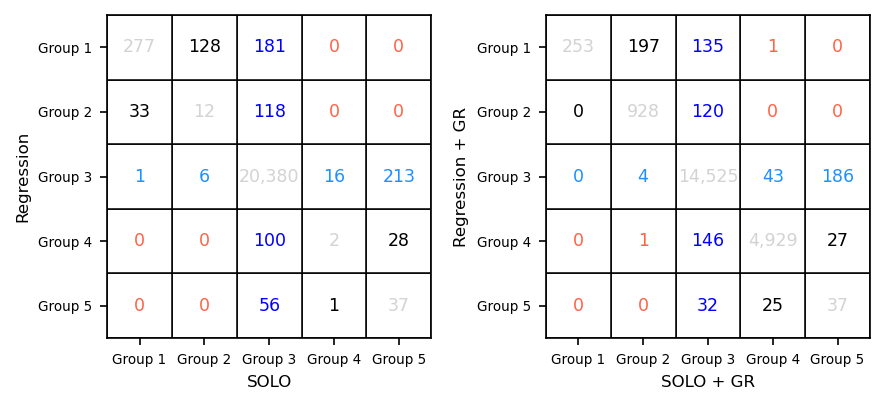

In [184]:
regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

regression_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

regression_GR_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

custom_coloring_heatmap([regression_vs_SOLO, regression_GR_vs_SOLO_GR])#, saveName="../results/Figures/comparison_heatmaps.svg")

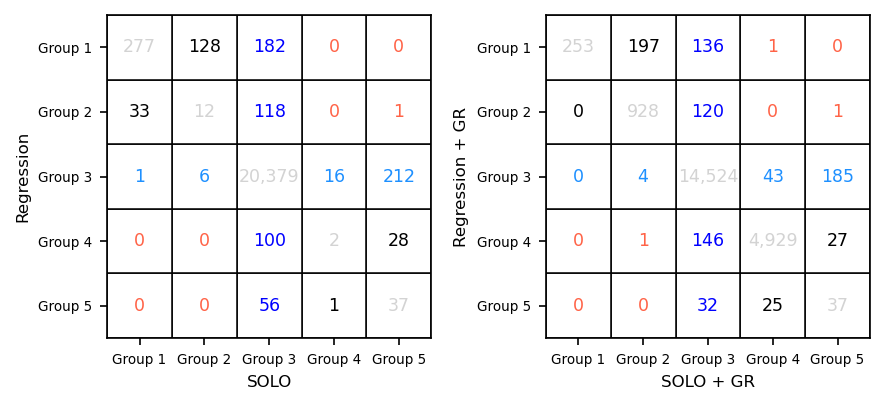

In [6]:
regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

regression_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

regression_GR_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

custom_coloring_heatmap([regression_vs_SOLO, regression_GR_vs_SOLO_GR], saveName="../results/Figures/comparison_heatmaps.svg")

In [7]:
# regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

# regression_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

# regression_GR_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

# custom_coloring_heatmap([regression_vs_SOLO, regression_vs_SOLO_GR, regression_GR_vs_SOLO_GR])

In [8]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_neutral_pval']]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES


In [9]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING'].str.contains('Assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_neutral_pval']]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
10283,Ethionamide,ethA,ethA_p.Pro209fs,frameshift,0.912978,0.001,0.003537,0.999,1.0,0.195313,...,0.000749,0.997538,0.998901,Uncertain,4) Not assoc w R - Interim,Downgrade to Interim,3) Uncertain significance,2) Assoc w R - Interim,4) Not assoc w R - Interim,4) Not assoc w R - Interim


In [10]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
1915,Capreomycin,rrs,rrs_n.514A>C,non_coding_transcript_exon_variant,1.124366,0.0,0.0,0.999,1.0,0.000584,...,0.091402,0.974525,0.979388,Assoc w R,2) Assoc w R - Interim,Upgrade to Interim,5) Not assoc w R,5) Not assoc w R,2) Assoc w R - Interim,2) Assoc w R - Interim
10335,Isoniazid,katG,katG_c.12A>G,synonymous_variant,1.099477,0.0,0.0,1.000,1.0,0.000222,...,0.001079,0.999866,1.000000,Assoc w R,1) Assoc w R,Both Assoc w R,3) Uncertain significance,4) Not assoc w R - Interim,1) Assoc w R,1) Assoc w R


In [11]:
minor_downgrades = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))][['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_R_PPV_LB', 'WHO_Present_SR', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_R_PPV_LB', 'ALL_Present_SR', 'SOLO FINAL CONFIDENCE GRADING']]

minor_downgrades

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_R_PPV_LB,WHO_Present_SR,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_R_PPV_LB,ALL_Present_SR,SOLO FINAL CONFIDENCE GRADING
1093,Bedaquiline,Rv0678_p.Met146Thr,1.182631,0.000000,0.004481,0.715086,11.0,1.179113,0.000000,5.033380e-24,0.120330,48.0,2) Assoc w R - Interim
17273,Pyrazinamide,pncA_p.Ala161fs,1.048530,0.000000,0.003630,0.025000,1.0,1.046219,0.000000,5.166047e-03,0.025000,1.0,2) Assoc w R - Interim
17346,Pyrazinamide,pncA_p.Arg154fs,1.037865,0.000000,0.018954,0.025000,1.0,1.037072,0.000000,2.187137e-02,0.025000,1.0,2) Assoc w R - Interim
17413,Pyrazinamide,pncA_p.Val155Ala,1.030951,0.046561,0.017887,0.067586,4.0,1.029785,0.063590,2.074692e-02,0.067586,4.0,2) Assoc w R - Interim
17415,Pyrazinamide,pncA_p.Val93Ala,1.028937,0.027430,0.022121,0.067586,4.0,1.027903,0.051676,2.713090e-02,0.067586,4.0,2) Assoc w R - Interim
17421,Pyrazinamide,pncA_p.Asp63_Ser67delinsGlu,1.027464,0.077214,0.080265,0.094299,3.0,1.027256,0.062094,6.560737e-02,0.094299,3.0,2) Assoc w R - Interim
17425,Pyrazinamide,pncA_p.Thr22fs,1.054718,0.000000,0.000933,0.158114,2.0,1.025642,0.041349,9.612209e-02,0.043272,6.0,2) Assoc w R - Interim


In [12]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))].query("Drug=='Pyrazinamide'")[['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_R_PPV', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_R_PPV', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_R_PPV,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_R_PPV,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
17273,pncA_p.Ala161fs,1.048530,0.000000,0.003630,1.000000,1.046219,0.000000,0.005166,1.000000,3) Uncertain significance,2) Assoc w R - Interim
17346,pncA_p.Arg154fs,1.037865,0.000000,0.018954,1.000000,1.037072,0.000000,0.021871,1.000000,3) Uncertain significance,2) Assoc w R - Interim
17413,pncA_p.Val155Ala,1.030951,0.046561,0.017887,0.500000,1.029785,0.063590,0.020747,0.500000,3) Uncertain significance,2) Assoc w R - Interim
17415,pncA_p.Val93Ala,1.028937,0.027430,0.022121,0.500000,1.027903,0.051676,0.027131,0.500000,3) Uncertain significance,2) Assoc w R - Interim
17421,pncA_p.Asp63_Ser67delinsGlu,1.027464,0.077214,0.080265,0.666667,1.027256,0.062094,0.065607,0.666667,3) Uncertain significance,2) Assoc w R - Interim
17425,pncA_p.Thr22fs,1.054718,0.000000,0.000933,1.000000,1.025642,0.041349,0.096122,0.333333,3) Uncertain significance,2) Assoc w R - Interim


In [13]:
# more details in the in_text_results.ipynb notebook
minor_upgrades = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]

len(minor_upgrades)

228

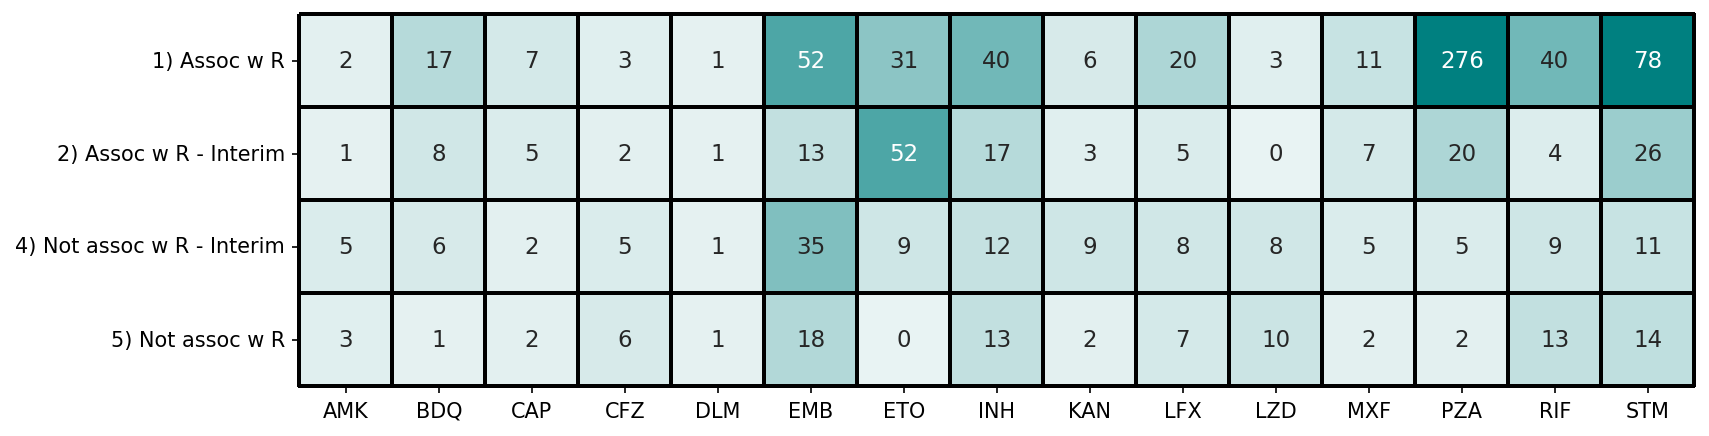

In [14]:
regression_drug_summary = pd.DataFrame(results_final.groupby("Drug")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"REGRESSION FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary = regression_drug_summary.pivot(index='confidence', columns='Drug', values='count').fillna(0).astype(int)

# don't plot Uncertain mutations so that it doesn't take away attention from the other 4 groups, which is what we want people to look at
regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '4) Not assoc w R - Interim', '5) Not assoc w R']]
# regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '3) Uncertain significance', '4) Not assoc w R - Interim', '5) Not assoc w R']]

fig, ax = plt.subplots(figsize=(12, 4))

sns.heatmap(regression_drug_summary, 
            fmt="g",
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            vmax=np.sort(regression_drug_summary.values.flatten())[-2], # use the second highest as the top
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 11},
            linewidths=1, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

ax.set_xticks(ticks=ax.get_xticks(), labels=[drug_abbr_dict[drug] for drug in regression_drug_summary.columns], rotation=0)
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticklabels(), rotation=0)

ax.set_xlabel('')
ax.set_ylabel('')
# plt.show()
plt.savefig("../results/Figures/summary_heatmap_by_drug.svg", format='svg', bbox_inches='tight')

# 5. INH Compensatory and Neutral Controls

In [71]:
# include all sites from -47 to -92 upstream of ahpC
ahpC_upstream_pos_region = np.arange(-92, -46).astype(str)

ahpC_exp_evidence_R = ['-81C>T', '-39C>T', '-54C>T', '-12C>T', '-51G>A', '-9G>A', '-48G>A', '-6G>A', '-52C>T', '-10C>T', '-72C>T', '-30C>T']
ahpC_exp_evidence_R = [f"ahpC_c.{var}" for var in ahpC_exp_evidence_R]

ahpC_exp_evidence_notR = ['-84T>C', '-42T>C', '-88G>A', '-46G>A', '-10G>A', '33G>A']
ahpC_exp_evidence_notR = [f"ahpC_c.{var}" for var in ahpC_exp_evidence_notR]

print(len(ahpC_exp_evidence_R), len(ahpC_exp_evidence_notR), len(ahpC_upstream_pos_region))

12 6 46


In [72]:
results_final.query("mutation in @ahpC_exp_evidence_notR")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
12139,Isoniazid,ahpC,ahpC_c.-84T>C,upstream_gene_variant,0.984898,0.402,0.554944,0.449,0.825122,0.775365,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12157,Isoniazid,ahpC,ahpC_c.-10G>A,upstream_gene_variant,0.983846,0.375,0.554944,0.479,0.825122,0.748744,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12356,Isoniazid,ahpC,ahpC_c.-88G>A,upstream_gene_variant,0.928051,0.023,0.092400,0.951,1.000000,1.000000,...,0.074576,0.853212,0.861495,Uncertain,3) Uncertain significance,Both Uncertain,5) Not assoc w R,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance


In [73]:
ahpC_save = results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')").loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')][['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

ahpC_save.loc[ahpC_save['mutation'].str.contains('|'.join(ahpC_upstream_pos_region)), 'Reference'] = 'Xpert'
ahpC_save.loc[ahpC_save['mutation'].isin(ahpC_exp_evidence_R), 'Reference'] = 'Experimental'

ahpC_save = ahpC_save.merge(MIC_results, on=['Drug', 'mutation'], how='left').sort_values(['REGRESSION FINAL CONFIDENCE GRADING', 'ALL_Odds_Ratio'], ascending=[True, False])

ahpC_save.to_csv("../tables/ahpC_compens.csv", index=False)

In [74]:
ahpC_save

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Reference,MIC_coef,MIC_BH_pval
0,Isoniazid,ahpC_c.-57C>T,1.158951,0.00000,Assoc w R,1.165863,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Xpert,0.046366,0.493554
1,Isoniazid,ahpC_c.-48G>A,1.167372,0.00000,Assoc w R,1.162905,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.017814,0.529301
2,Isoniazid,ahpC_c.-52C>T,1.138477,0.00000,Assoc w R,1.140174,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.039229,0.529301
3,Isoniazid,ahpC_c.-54C>T,1.124465,0.00000,Assoc w R,1.130568,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.030262,0.529301
4,Isoniazid,ahpC_c.-76T>A,1.138471,0.00000,Assoc w R,1.098706,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Xpert,0.057983,0.404069
5,Isoniazid,ahpC_c.-72C>T,1.044939,0.00488,Uncertain,1.082337,0.0,Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,3) Uncertain significance,Experimental,0.110329,0.000000


In [19]:
results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
3) Uncertain significance     60
1) Assoc w R                   5
4) Not assoc w R - Interim     2
2) Assoc w R - Interim         1
Name: count, dtype: int64

In [20]:
results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')")[['mutation', 'REGRESSION FINAL CONFIDENCE GRADING']].loc[results_final['REGRESSION FINAL CONFIDENCE GRADING']=='4) Not assoc w R - Interim']

,mutation,REGRESSION FINAL CONFIDENCE GRADING
12307,ahpC_c.-80A>G,4) Not assoc w R - Interim
12322,ahpC_c.-79C>T,4) Not assoc w R - Interim


In [21]:
'ahpC_c.-80A>G' in ahpC_exp_evidence_R, 'ahpC_c.-79C>T' in ahpC_exp_evidence_R

(False, False)

In [22]:
'ahpC_c.-80A>G' in ahpC_exp_evidence_notR, 'ahpC_c.-79C>T' in ahpC_exp_evidence_notR

(False, False)

In [23]:
results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')")[['mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'ALL_Odds_Ratio', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'ALL_S_PPV_LB', 'ALL_Present_R', 'ALL_Present_S']].loc[results_final['REGRESSION FINAL CONFIDENCE GRADING']=='4) Not assoc w R - Interim']

,mutation,REGRESSION FINAL CONFIDENCE GRADING,ALL_Odds_Ratio,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,ALL_S_PPV_LB,ALL_Present_R,ALL_Present_S
12307,ahpC_c.-80A>G,4) Not assoc w R - Interim,0.971757,Uncertain,Not assoc w R,0.630583,0.0,8.0
12322,ahpC_c.-79C>T,4) Not assoc w R - Interim,0.968121,Uncertain,Not assoc w R,0.630583,0.0,8.0


In [26]:
# all Uncertain by regression
results_final.query("mutation in @ahpC_exp_evidence_notR")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
12139,Isoniazid,ahpC,ahpC_c.-84T>C,upstream_gene_variant,0.984898,0.402,0.554944,0.449,0.825122,0.775365,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12157,Isoniazid,ahpC,ahpC_c.-10G>A,upstream_gene_variant,0.983846,0.375,0.554944,0.479,0.825122,0.748744,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12356,Isoniazid,ahpC,ahpC_c.-88G>A,upstream_gene_variant,0.928051,0.023,0.092400,0.951,1.000000,1.000000,...,0.074576,0.853212,0.861495,Uncertain,3) Uncertain significance,Both Uncertain,5) Not assoc w R,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance


# 6. Direct Association-Based Prediction Comparison between SOLO and Regression

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [7]:
def single_metric_solo_regression_comparison(drugs_lst, metric="Sens", remove_discrepancies=False, include_regression_GR=True, saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(11, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:

        reg_model_suffix = ''
    
        if remove_discrepancies and drug in ['Capreomycin', 'Isoniazid']:
            reg_model_suffix += '_remove_discrepancies' # only for regression, not SOLO
    
        if drug != "Pretomanid":
            stats_solo_initial = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_SOLO.csv"))
            stats_solo_initial['Drug'] = drug
            stats_solo_initial['Model'] = 'SOLO'
            
            stats_solo_final = solo_binary_stats.query("Drug==@drug").reset_index()
            stats_solo_final['Model'] = 'SOLO + GR'
            
            stats_regression = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75{reg_model_suffix}_V2.csv"))
            stats_regression['Drug'] = drug
                
            plot_df.append(stats_solo_initial)
            plot_df.append(stats_solo_final)
            plot_df.append(stats_regression)
            
            if include_regression_GR:
                
                results_fName_GR = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_GR{reg_model_suffix}_V2.csv")
                stats_regression_GR = pd.read_csv(results_fName_GR)
                stats_regression_GR['Drug'] = drug
                stats_regression_GR['Model'] = 'Regression + GR'

                plot_df.append(stats_regression_GR)

    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')
    
    # Categories and metric names
    if include_regression_GR:
        categories = ['SOLO', 'SOLO + GR', 'Regression', 'Regression + GR']
    else:
        categories = ['SOLO', 'SOLO + GR', 'Regression']

    # SOLO green, Regression orange
    colors = {'SOLO': sns.color_palette("Set3").as_hex()[0],#sns.color_palette("Set2")[0], 
              'Regression': sns.color_palette("Set3").as_hex()[5], #sns.color_palette("Set2")[1], 
              'Regression + GR': sns.color_palette("Set3").as_hex()[8],
              'SOLO + GR': sns.color_palette("Set3").as_hex()[2], #sns.color_palette("Set2")[2]
             }
    
    # colors = dict(zip(categories, np.concatenate([sns.color_palette("Paired")[:2], sns.color_palette("Paired")[6:8]])))
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')#, alpha=0.75)
            ax.bar_label(patch, label_type='center', fmt='%.1f', fontsize=9)
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    # plt.legend(bbox_to_anchor=(0.08, -0.17), loc="lower right", ncol=len(categories))
    plt.legend(bbox_to_anchor=(-1.6, -0.17), loc="lower center", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if remove_discrepancies:
            saveName = saveName.replace('.svg', '') + "_remove_discrepancies.svg"
            
        plt.savefig(saveName, format='svg', bbox_inches="tight")

    plt.close()
    return plot_df

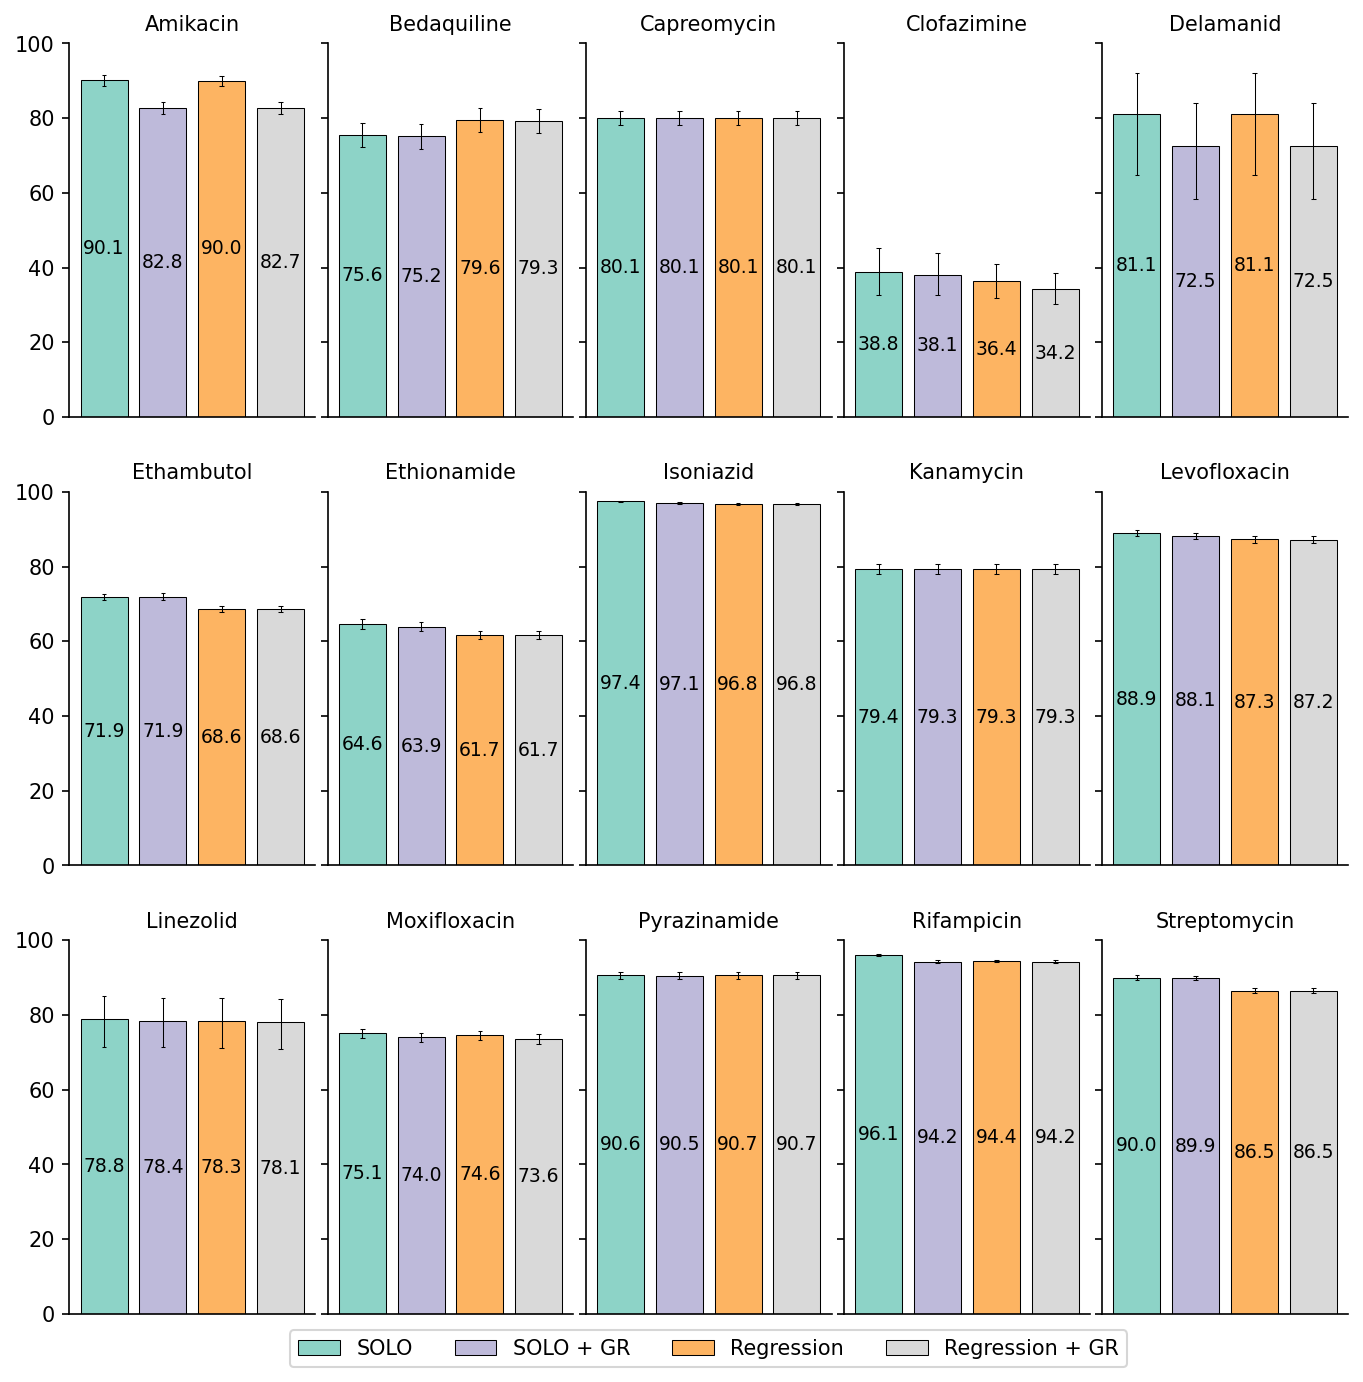

In [75]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", remove_discrepancies=False, saveName="../results/Figures/PPV_comparison.svg")
binary_metrics_df_remove_discrepancies = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", remove_discrepancies=True)

# save
binary_metrics_df.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics.csv")
binary_metrics_df_remove_discrepancies.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics_remove_discrepancies.csv")

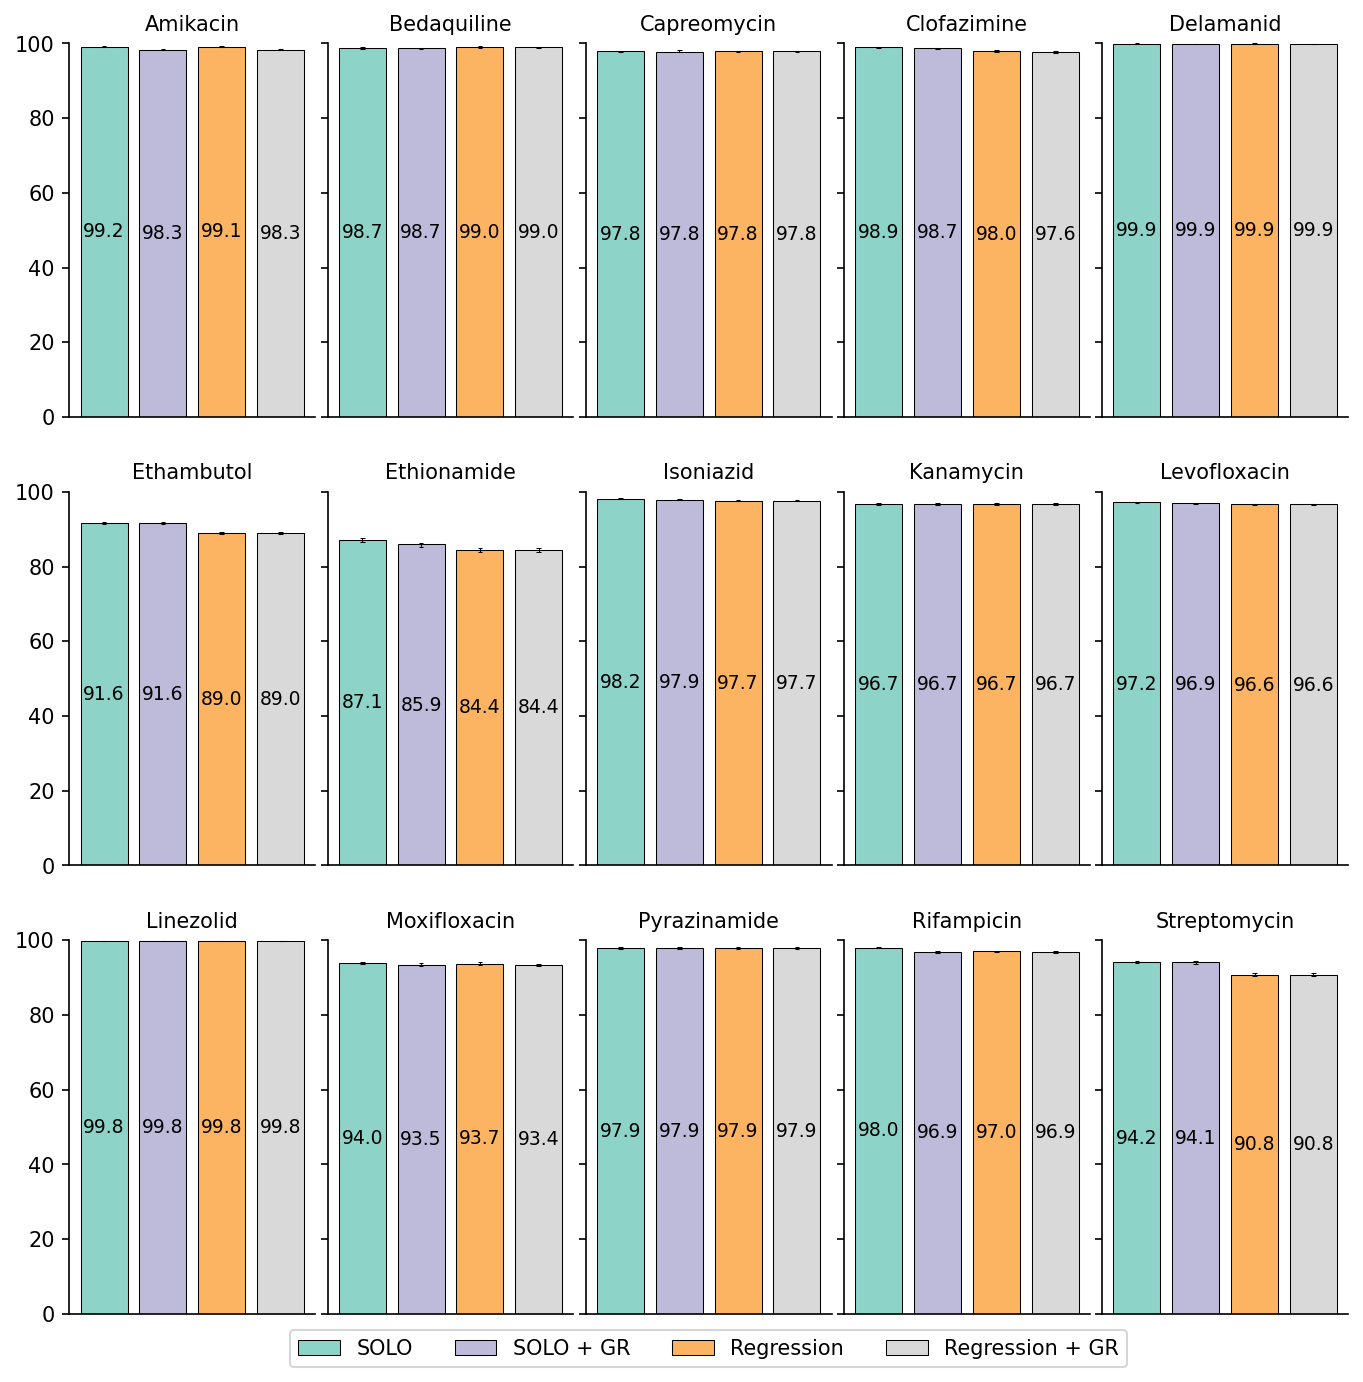

In [11]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", remove_discrepancies=False)#, saveName="../results/Figures/PPV_comparison.svg")
# binary_metrics_df_remove_discrepancies = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", remove_discrepancies=True)

In [12]:
results_final_V2 = pd.read_csv("../results/Nov2024_Tier1_V2.csv")

In [15]:
results_final_V2.query("Reason=='Downgrade to Uncertain due to PPV discrepancy'")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
1915,Capreomycin,rrs,rrs_n.514A>C,non_coding_transcript_exon_variant,1.124366,0.0,0.0,0.999,1.0,5.836759e-04,...,0.091402,0.974525,0.979388,Assoc w R,3) Uncertain significance,Downgrade to Uncertain due to PPV discrepancy,5) Not assoc w R,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance
8772,Ethionamide,ethA,ethA_p.Thr314Ile,missense_variant,1.245594,0.0,0.0,1.000,1.0,3.018152e-10,...,0.020413,0.987792,0.991069,Assoc w R,3) Uncertain significance,Downgrade to Uncertain due to PPV discrepancy,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance


In [96]:
binary_metrics_df_remove_discrepancies.query("Drug=='Capreomycin'")[['Sens', 'Spec', 'PPV']]

,Sens,Spec,PPV
Model,,,
SOLO,0.660533,0.978404,0.80141
SOLO + GR,0.662000,0.978000,0.80100
Regression,0.660533,0.978404,0.80141
Regression + GR,0.660533,0.978404,0.80141


In [76]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", remove_discrepancies=False, saveName="../results/Figures/Sens_comparison.svg")

In [77]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", remove_discrepancies=False, saveName="../results/Figures/Spec_comparison.svg")

In [78]:
# F1 scores: PPV * sens / (PPV + sens)
print(f"SOLO F1: {binary_metrics_df.loc['SOLO']['F1'].mean()*100}")
print(f"SOLO + GR F1: {binary_metrics_df.loc['SOLO + GR']['F1'].mean()*100}")
print(f"Regression F1: {binary_metrics_df.loc['Regression']['F1'].mean()*100}")
print(f"Regression F1 remove discrepancies: {binary_metrics_df_remove_discrepancies.loc['Regression']['F1'].mean()*100}")

SOLO F1: 69.24224388943
SOLO + GR F1: 69.94689238258516
Regression F1: 70.18617984009417
Regression F1 remove discrepancies: 70.51340676724078


In [122]:
binary_metrics_df.query("Drug in ['Rifampicin', 'Isoniazid']")[['Drug', 'Sens', 'Spec']]

,Drug,Sens,Spec
Model,,,
SOLO,Isoniazid,0.906926,0.981949
SOLO + GR,Isoniazid,0.916000,0.979000
Regression,Isoniazid,0.927784,0.976689
Regression + GR,Isoniazid,0.927784,0.976689
SOLO,Rifampicin,0.902675,0.979915
SOLO + GR,Rifampicin,0.933000,0.969000
Regression,Rifampicin,0.928355,0.970132
Regression + GR,Rifampicin,0.932981,0.968868


In [124]:
binary_metrics_df.query("Drug in ['Levofloxacin', 'Moxifloxacin']")[['Drug', 'Sens', 'Spec']]

,Drug,Sens,Spec
Model,,,
SOLO,Moxifloxacin,0.849628,0.939530
SOLO + GR,Moxifloxacin,0.857000,0.935000
Regression,Moxifloxacin,0.856576,0.937183
Regression + GR,Moxifloxacin,0.861538,0.933664
SOLO,Levofloxacin,0.840654,0.971708
SOLO + GR,Levofloxacin,0.848000,0.969000
Regression,Levofloxacin,0.855124,0.966178
Regression + GR,Levofloxacin,0.855124,0.966132


In [121]:
binary_metrics_df.query("Drug in ['Clofazimine']")[['Spec', 'Drug']]

,Spec,Drug
Model,,
SOLO,0.989246,Clofazimine
SOLO + GR,0.987000,Clofazimine
Regression,0.980108,Clofazimine
Regression + GR,0.976383,Clofazimine


In [79]:
# difference between regression and SOLO without GR
diff_df_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_initial.index.values:
    for metric in diff_df_SOLO_initial.columns:
        diff_df_SOLO_initial.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO", metric]

diff_df_SOLO_initial['combined_diff'] = (np.abs(diff_df_SOLO_initial['Sens']) + np.abs(diff_df_SOLO_initial['Spec'])) / 2

In [91]:
diff_df_SOLO_initial.query("Sens > 0").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1,combined_diff
Ethambutol,0.102349,-0.026515,-0.032461,0.026667,0.021672,0.064432
Clofazimine,0.096012,-0.009138,-0.023955,0.003962,0.079493,0.052575
Streptomycin,0.095389,-0.033384,-0.034911,0.051888,0.033319,0.064387
Ethionamide,0.093875,-0.037018,-0.029687,0.027088,0.021617,0.065447
Rifampicin,0.025681,-0.009783,-0.016485,0.012684,0.005438,0.017732
Isoniazid,0.020858,-0.00526,-0.006523,0.013908,0.007952,0.013059
Capreomycin,0.015496,-0.021532,-0.12734,0.001013,-0.049135,0.018514
Levofloxacin,0.014471,-0.005529,-0.016906,0.003496,-0.000618,0.01
Linezolid,0.010695,-0.000113,-0.00464,0.000219,0.009944,0.005404
Moxifloxacin,0.006948,-0.002346,-0.005634,0.001411,-0.000163,0.004647


In [92]:
diff_df_SOLO_initial.query("Spec < 0").sort_values("Spec", ascending=True)

,Sens,Spec,PPV,NPV,F1,combined_diff
Ethionamide,0.093875,-0.037018,-0.029687,0.027088,0.021617,0.065447
Streptomycin,0.095389,-0.033384,-0.034911,0.051888,0.033319,0.064387
Ethambutol,0.102349,-0.026515,-0.032461,0.026667,0.021672,0.064432
Capreomycin,0.015496,-0.021532,-0.12734,0.001013,-0.049135,0.018514
Rifampicin,0.025681,-0.009783,-0.016485,0.012684,0.005438,0.017732
Clofazimine,0.096012,-0.009138,-0.023955,0.003962,0.079493,0.052575
Levofloxacin,0.014471,-0.005529,-0.016906,0.003496,-0.000618,0.01
Isoniazid,0.020858,-0.00526,-0.006523,0.013908,0.007952,0.013059
Moxifloxacin,0.006948,-0.002346,-0.005634,0.001411,-0.000163,0.004647
Kanamycin,0.003923,-0.000381,-0.001032,0.000615,0.001601,0.002152


In [80]:
# diff_df_SOLO_final = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

# for drug in diff_df_SOLO_final.index.values:
#     for metric in diff_df_SOLO_final.columns:
#         diff_df_SOLO_final.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO + GR", metric]

In [97]:
# difference between regression and regression + GR
diff_df_regression_GR = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_regression_GR.index.values:
    for metric in diff_df_regression_GR.columns:
        diff_df_regression_GR.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression + GR", metric] - binary_metrics_df.query("Drug==@drug").loc["Regression", metric]

In [98]:
diff_df_regression_GR.query("Sens > 0").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Amikacin,0.039113,-0.008457,-0.073253,0.003875,-0.006034
Delamanid,0.027778,-0.000606,-0.085321,0.000573,0.036612
Clofazimine,0.019202,-0.003725,-0.021579,0.00074,0.005843
Linezolid,0.005348,-0.000057,-0.002189,0.00011,0.004888
Moxifloxacin,0.004963,-0.003519,-0.009355,0.000955,-0.003266
Rifampicin,0.004626,-0.001263,-0.001947,0.002367,0.001384
Bedaquiline,0.001929,-0.000229,-0.003105,0.000134,0.000586
Pyrazinamide,0.000226,-0.000118,-0.000451,0.000048,-0.000063


In [113]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'] != results_final['REGRESSION + GRADING RULES']) & (results_final['REGRESSION + GRADING RULES'].str.contains('Assoc w R'))].query("Drug=='Delamanid'").gene.unique()

array(['ddn', 'fgd1', 'fbiC', 'fbiA', 'fbiB', 'Rv2983'], dtype=object)

In [114]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'] != results_final['REGRESSION + GRADING RULES']) & (results_final['REGRESSION + GRADING RULES'].str.contains('Assoc w R'))].query("Drug=='Clofazimine'").gene.unique()

array(['Rv0678', 'pepQ'], dtype=object)

In [107]:
who_variants.loc[pd.isnull(who_variants['INITIAL CONFIDENCE GRADING'])]#.query("drug=='Bedaquiline' & gene=='atpE'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
1096,Bedaquiline,atpE,p.Asp28Ala,atpE_p.Asp28Ala,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5
1097,Bedaquiline,atpE,p.Asp28Gly,atpE_p.Asp28Gly,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5
1098,Bedaquiline,atpE,p.Asp28Val,atpE_p.Asp28Val,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5
15311,Linezolid,rrl,n.2270G>C,rrl_n.2270G>C,1,non_coding_transcript_exon_variant,1475927,NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5
15440,Linezolid,rrl,n.2689A>T,rrl_n.2689A>T,1,non_coding_transcript_exon_variant,1476346,NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5
15453,Linezolid,rrl,n.2746G>A,rrl_n.2746G>A,1,non_coding_transcript_exon_variant,1476403,NaN,NaN,NaN,...,Selection evidence,2) Assoc w R - Interim,NaN,New AwRI,NaN,NaN,yes,Selection,NaN,5


In [102]:
who_variants.query("Comment=='Consider that this variant might indicate that the isolate is M. canettii, which is intrinsically PZA resistant'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
17425,Pyrazinamide,pncA,c.138A>G,pncA_c.138A>G,1,synonymous_variant,"(see ""Genomic_coordinates"" sheet)",NaN,NaN,NaN,...,Silent mutation,4) Not assoc w R - Interim,Consider that this variant might indicate that...,Now listed,NaN,Silent mutation,yes,NaN,Q,0


In [83]:
def print_summaries_of_metric_comparisons(df, metric):

    reg_better = df.query(f"{metric} > 0")
    solo_better = df.query(f"{metric} < 0")
    reg_solo_same = df.query(f"{metric} == 0")

    print(f"Regression better for {len(reg_better)}")
    print(f"SOLO better for {len(solo_better)}")
    print(f"Models same for {len(reg_solo_same)}")

    if len(reg_better) > len(solo_better):
        print(f"Difference range: {reg_better[metric].min()*100}-{reg_better[metric].max()*100}")
    else:
        print(f"Difference range: {solo_better[metric].min()*100}-{solo_better[metric].max()*100}")

In [84]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'Sens')

Regression better for 13
SOLO better for 1
Models same for 1
Difference range: 0.08064516129032695-10.23489932885906


In [85]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'Spec')

Regression better for 2
SOLO better for 12
Models same for 1
Difference range: -3.70181586492514--0.011340440009088848


In [86]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'PPV')

Regression better for 2
SOLO better for 12
Models same for 1
Difference range: -12.733960841365366--0.10318000784167447


In [88]:
diff_df_SOLO_initial.Sens.mean()*100, diff_df_SOLO_initial.Spec.mean()*100, diff_df_SOLO_initial.PPV.mean()*100

(3.2266650671183275, -0.9877841877339739, -1.7286999128927758)

In [138]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].shape

(751, 66)

In [143]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("WHO_S_PPV_UB > 0.75 & ALL_S_PPV_UB > 0.75").gene.unique()

array(['pncA'], dtype=object)

In [160]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("WHO_S_PPV_LB >= 0.5 & ALL_S_PPV_LB >= 0.5")[['Drug', 'mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING']]

,Drug,mutation,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING
1915,Capreomycin,rrs_n.514A>C,Uncertain,Assoc w R,2) Assoc w R - Interim,5) Not assoc w R
8772,Ethionamide,ethA_p.Thr314Ile,Assoc w R,Assoc w R,1) Assoc w R,3) Uncertain significance


In [172]:
results_final.query("Drug=='Bedaquiline' & mutation=='mmpS5_c.-74G>T'")[['WHO_S_PPV_LB', 'ALL_S_PPV_LB']]

,WHO_S_PPV_LB,ALL_S_PPV_LB
1089,0.01858,0.653791


In [177]:
# finally, downgrade variants that are in Groups 1-2 at this point, but have high susceptible PPV values in both WHO and ALL datasets
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) &
                  (results_final['WHO_S_PPV_LB'] >= 0.5) &
                  (results_final['ALL_S_PPV_LB'] >= 0.5),
                    ['Reason', 'REGRESSION FINAL CONFIDENCE GRADING']
                 ] = ['Downgrade to Uncertain due to discrepancy', '3) Uncertain significance']

In [180]:
# do the same thing for Not assoc w R variants, but exclude variants that are neutral. Just want to find the variants that are graded Not assoc w R in either dataset,
# leading to a final Not assoc w R grading (meaning S-associated) but have high R_PPV lower bound
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')) &
                  ((results_final['Initial confidence grading WHO dataset']=='Not assoc w R') | 
                  (results_final['Initial confidence grading ALL dataset']=='Not assoc w R')) &
                  (results_final['WHO_R_PPV_LB'] >= 0.5) &
                  (results_final['ALL_R_PPV_LB'] >= 0.5),
                    ['Reason', 'REGRESSION FINAL CONFIDENCE GRADING']
                 ] = ['Downgrade to Uncertain due to discrepancy', '3) Uncertain significance']

In [182]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R', case=True)) & (results_final['SOLO FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R', case=True))][['mutation', 'WHO_S_PPV_LB', 'ALL_S_PPV_LB']]

,mutation,WHO_S_PPV_LB,ALL_S_PPV_LB
10335,katG_c.12A>G,0.0,0.0


In [ ]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("WHO_S_PPV_LB >= 0.5 & ALL_S_PPV_LB >= 0.5")[['Drug', 'mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING']]

In [161]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')].query("WHO_R_PPV_LB >= 0.5 & ALL_R_PPV_LB >= 0.5")[['Drug', 'mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING']]

,Drug,mutation,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING
11404,Isoniazid,katG_c.1095G>A,Uncertain,Neutral,4) Not assoc w R - Interim,3) Uncertain significance
11410,Isoniazid,katG_c.-62C>A,Uncertain,Neutral,4) Not assoc w R - Interim,3) Uncertain significance


In [ ]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("WHO_S_PPV_LB >= 0.5 & ALL_S_PPV_LB >= 0.5")[['Drug', 'mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'SOLO INITIAL CONFIDENCE GRADING']]

In [154]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')].query("WHO_R_PPV_LB > 0.5 & ALL_R_PPV_LB > 0.5")[['Drug', 'mutation', 'WHO_R_PPV', 'WHO_S_PPV', 'ALL_R_PPV', 'ALL_S_PPV', 'SOLO INITIAL CONFIDENCE GRADING', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'ALL_Present_R', 'ALL_Present_S']]

,Drug,mutation,WHO_R_PPV,WHO_S_PPV,ALL_R_PPV,ALL_S_PPV,SOLO INITIAL CONFIDENCE GRADING,WHO_Present_R,WHO_Present_S,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,ALL_Present_R,ALL_Present_S
11404,Isoniazid,katG_c.1095G>A,1.0,0.0,0.974359,0.025641,3) Uncertain significance,18.0,0.0,Uncertain,Neutral,38.0,1.0
11410,Isoniazid,katG_c.-62C>A,1.0,0.0,0.987500,0.012500,3) Uncertain significance,17.0,0.0,Uncertain,Neutral,79.0,1.0


In [147]:
results_final.loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("WHO_S_PPV > 0.5 & ALL_S_PPV > 0.5")[['Drug', 'mutation', 'WHO_R_PPV', 'WHO_S_PPV', 'ALL_R_PPV', 'ALL_S_PPV', 'SOLO INITIAL CONFIDENCE GRADING']]

,Drug,mutation,WHO_R_PPV,WHO_S_PPV,ALL_R_PPV,ALL_S_PPV,SOLO INITIAL CONFIDENCE GRADING
1915,Capreomycin,rrs_n.514A>C,0.296830,0.703170,0.306452,0.693548,5) Not assoc w R
2753,Clofazimine,Rv0678_LoF,0.480620,0.519380,0.380753,0.619247,1) Assoc w R
2755,Clofazimine,Rv1979c_p.Arg409Gln,0.142857,0.857143,0.371560,0.628440,3) Uncertain significance
2756,Clofazimine,Rv0678_p.Asp47fs,0.476190,0.523810,0.435897,0.564103,3) Uncertain significance
4625,Ethambutol,embB_p.Ser297Ala,0.488215,0.511785,0.465257,0.534743,3) Uncertain significance
4683,Ethambutol,embA_c.-8C>A,0.446154,0.553846,0.413333,0.586667,3) Uncertain significance
8766,Ethionamide,ethA_p.Asn379Asp,0.437037,0.562963,0.423611,0.576389,1) Assoc w R
8772,Ethionamide,ethA_p.Thr314Ile,0.375661,0.624339,0.333333,0.666667,3) Uncertain significance
8774,Ethionamide,ethA_c.-7T>C,0.439252,0.560748,0.438017,0.561983,1) Assoc w R
8821,Ethionamide,ethA_p.Trp256*,0.478261,0.521739,0.433333,0.566667,3) Uncertain significance


In [41]:
who_variants.query("drug=='Amikacin'").loc[who_variants['FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sort_values("variant")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
17,Amikacin,eis,c.-14C>T,eis_c.-14C>T,1,upstream_gene_variant,2715346,1.0,200.0,72.0,...,WHO-endorsed gDST assay,2) Assoc w R - Interim,Can only confer resistance if genetically link...,DOWN from AwR to AwRI,NaN,NaN,yes,WHO-end. gDST,A,3
475,Amikacin,rrs,n.1401A>G,rrs_n.1401A>G,1,non_coding_transcript_exon_variant,1473246,1.0,1648.0,1526.0,...,NaN,1) Assoc w R,NaN,No change,NaN,NaN,yes,NaN,NaN,1
477,Amikacin,rrs,n.1402C>T,rrs_n.1402C>T,1,non_coding_transcript_exon_variant,1473247,1.0,18.0,6.0,...,WHO-endorsed gDST assay,2) Assoc w R - Interim,NaN,No change,NaN,NaN,yes,WHO-end. gDST,NaN,1
527,Amikacin,rrs,n.1484G>T,rrs_n.1484G>T,1,non_coding_transcript_exon_variant,1473329,1.0,17.0,12.0,...,NaN,1) Assoc w R,NaN,UP from AwRI to AwR,NaN,NaN,yes,NaN,NaN,4


In [82]:
results_final.query("Drug=='Amikacin'").loc[results_final['REGRESSION + GRADING RULES'].str.contains('Assoc w R')].sort_values("mutation")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
1,Amikacin,eis,eis_c.-14C>T,upstream_gene_variant,1.392469,0.000,0.000000,1.000,1.000000,1.477512e-39,...,0.045699,0.988936,0.991616,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
2,Amikacin,eis,eis_p.Trp36Arg,missense_variant,1.034915,0.088,0.414118,0.404,0.577143,2.682682e-01,...,0.006159,0.999587,0.999971,Assoc w R,2) Assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,2) Assoc w R - Interim,2) Assoc w R - Interim
0,Amikacin,rrs,rrs_n.1401A>G,non_coding_transcript_exon_variant,4.599413,0.000,0.000000,1.000,1.000000,0.000000e+00,...,0.732114,0.990498,0.992973,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
4,Amikacin,rrs,rrs_n.1402C>T,non_coding_transcript_exon_variant,1.124324,0.000,0.000000,0.983,1.000000,3.697509e-09,...,0.007295,0.998835,0.999605,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
3,Amikacin,rrs,rrs_n.1484G>T,non_coding_transcript_exon_variant,1.185034,0.000,0.000000,1.000,1.000000,3.182822e-25,...,0.010560,0.999013,0.999708,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R


In [125]:
def single_metric_HET_comparison(drugs_lst, metric="Sens", model_1='model_stats_AF75', model_2='model_stats_AF25', remove_discrepancies=False, title=None, saveName=None):

    # model_stats_AF75_withLoF_gradingRules
    
    plot_df = []
    
    if '25' in model_2:
        group_1 = 'AF = 75%'
        group_2 = 'AF = 25%'
    else:
        group_1 = 'Regression'
        group_2 = 'Regression + GR'
        
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":

            if remove_discrepancies and drug in ['Capreomycin', 'Isoniazid']:
                fName_1 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_1}_remove_discrepancies.csv")
                fName_2 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_2}_remove_discrepancies.csv")
                
            else:
                fName_1 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_1}.csv")
                fName_2 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_2}.csv")
                
            stats_1 = pd.read_csv(fName_1)
            stats_2 = pd.read_csv(fName_2)

            stats_1['Model'] = [group_1]
            stats_1['Drug'] = drug
            
            stats_2['Model'] = [group_2]
            stats_2['Drug'] = drug

            plot_df.append(stats_1)
            plot_df.append(stats_2)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)
    
    # Categories and metric names
    categories = plot_df.index.unique()

    # keep orange color (index 1) for regression, then select the next color for +HETs
    colors = {group_1: sns.color_palette("Set3").as_hex()[5], 'AF = 25%': sns.color_palette("Set3").as_hex()[4], 'Regression + GR': sns.color_palette("Set3").as_hex()[8]}
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)

        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)

    if title is not None:
        plt.suptitle(title)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches="tight")

    plt.close()
    return plot_df

In [126]:
HET_results = single_metric_HET_comparison(drugs_lst, metric="Sens", model_2='model_stats_AF25', saveName="../results/Figures/Sens_comparison_withHETs.svg")

_ = single_metric_HET_comparison(drugs_lst, metric="Spec", model_2='model_stats_AF25', saveName="../results/Figures/Spec_comparison_withHETs.svg")
_ = single_metric_HET_comparison(drugs_lst, metric="PPV", model_2='model_stats_AF25', saveName="../results/Figures/PPV_comparison_withHETs.svg")

# save
HET_results.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics_withHETs.csv")

In [127]:
diff_df_HET = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET.loc[drug, metric] = HET_results.query("Drug==@drug").loc["AF = 25%", metric] - HET_results.query("Drug==@drug").loc["AF = 75%", metric]

In [131]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.010861,0.007582,0.069685
Moxifloxacin,0.046898,-0.003626,-0.000534,0.010104,0.019414
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002684,-0.003272,0.003889,0.013615
Amikacin,0.024194,-0.00099,-0.006994,0.002516,0.012591
Kanamycin,0.023536,-0.001285,-0.001161,0.003756,0.011722
Pyrazinamide,0.021214,-0.001066,-0.001936,0.005045,0.011261
Ethionamide,0.013929,-0.003568,-0.000948,0.004524,0.00462
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [132]:
HET_results.query("Drug in ['Clofazimine', 'Bedaquiline', 'Moxifloxacin', 'Levofloxacin']").loc['AF = 25%', ['Drug', 'Sens', 'Sens_lb', 'Sens_ub']]

,Drug,Sens,Sens_lb,Sens_ub
Model,,,,
AF = 25%,Bedaquiline,0.589200,0.558556,0.619336
AF = 25%,Clofazimine,0.277696,0.244252,0.313091
AF = 25%,Moxifloxacin,0.903474,0.893938,0.912421
AF = 25%,Levofloxacin,0.899728,0.891762,0.907294


# Volcano Plots of MIC Results for Mutations 1) Assoc w R by Regression and Uncertain by SOLO

## First, are there are any variants determined Neutral from the binary data but have a significant MIC coefficient?

In [33]:
neutral_variants = results_final.loc[((results_final['Initial confidence grading WHO dataset'] == 'Neutral') | (results_final['Initial confidence grading ALL dataset'] == 'Neutral')) & (results_final['REGRESSION FINAL CONFIDENCE GRADING'] != '3) Uncertain significance')]

neutral_variants = neutral_variants.merge(MIC_results, how='left')

len(neutral_variants)

91

In [34]:
neutral_variants.query("MIC_BH_pval <= 0.05")[['Drug', 'mutation', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval']]

,Drug,mutation,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval
8,Clofazimine,Rv1979c_c.-129A>G,Neutral,Uncertain,5) Not assoc w R,5) Not assoc w R,0.042054,0.000000
66,Linezolid,rrl_n.2779A>G,Uncertain,Neutral,4) Not assoc w R - Interim,3) Uncertain significance,0.026713,0.014727


In [36]:
# drug = 'Linezolid'

# df_genos = pd.read_csv(os.path.join(analysis_dir, drug, "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])

# df_genos['mutation'] = df_genos['resolved_symbol'] + '_' + df_genos['variant_category']

# del df_genos['resolved_symbol']
# del df_genos['variant_category']

# df_MIC = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))

# df_MIC_norm, most_common_medium = normalize_MICs_return_dataframe(drug, df_MIC, cc_df, keep_single_medium=False)

# df_MIC_norm = df_MIC_norm.merge(lineages, left_on='sample_id', right_on='Sample_ID')

In [37]:
# variant = 'rrl_n.2779A>G'

# samples_with_variant = df_genos.query("mutation==@variant & variant_allele_frequency > 0.75").sample_id.unique()
# print(len(samples_with_variant))

# df_MIC_norm['variant'] = df_MIC_norm['sample_id'].isin(samples_with_variant).astype(int)

In [38]:
# df_genos.query("sample_id in @samples_with_variant & mutation != @variant & variant_allele_frequency > 0.75")

In [39]:
# sns.histplot(data=df_MIC_norm,
#              x='norm_MIC',
#              hue='variant',
#              log_scale=2,
#              palette='Set2',
#              common_norm=False,
#              multiple='dodge',
#              stat='probability',
#              shrink=2
#             )

# sns.despine()
# plt.show()

In [40]:
MIC_pval_thresh = 0.05

# variants graded in not Uncertain by regression and Uncertain by DA
# already includes filter for Num_Isolates ≥ 5 when grading.
# also exclude variant that are Neutral in the WHO dataset because we wouldn't expect them to have significant MIC coefficients
search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['3) Uncertain significance'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['Initial confidence grading WHO dataset'] != 'Neutral') & (results_final['Initial confidence grading ALL dataset'] != 'Neutral')].reset_index(drop=True)

# search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')]

print(f"Examining MIC results for {len(search_df)} variants")
search_df = search_df.merge(MIC_results, on=['Drug', 'mutation'], how='left')

# keep only those with MIC results
MIC_test_variants = search_df.loc[(~pd.isnull(search_df['MIC_BH_pval']))]
print(f"{len(MIC_test_variants)}/{len(search_df)} ({np.round(len(MIC_test_variants)/len(search_df)*100, 1)}%) variants have MIC results")

Examining MIC results for 372 variants
301/372 (80.9%) variants have MIC results


In [56]:
# N = 235
MIC_test_variants_WHO_significant = MIC_test_variants.query("(WHO_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (WHO_BH_pval <= 0.01 & predicted_effect in @silent_lst)")

# N = 171
# MIC_test_variants_WHO_significant = MIC_test_variants.loc[MIC_test_variants['Initial confidence grading WHO dataset']!='Uncertain']

# N = 295 in both
MIC_test_variants_ALL_significant = MIC_test_variants.query("(ALL_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (ALL_BH_pval <= 0.01 & predicted_effect in @silent_lst)")

# MIC_test_variants_ALL_significant = MIC_test_variants.loc[MIC_test_variants['Initial confidence grading ALL dataset']!='Uncertain']


print(f"{len(MIC_test_variants_WHO_significant)} variants have significant WHO associations and were tested in the MIC models")
print(f"{len(MIC_test_variants_ALL_significant)} variants have significant ALL associations and were tested in the MIC models")

232 variants have significant WHO associations and were tested in the MIC models
295 variants have significant ALL associations and were tested in the MIC models


In [57]:
MIC_test_variants_WHO_MIC_significant = MIC_test_variants_WHO_significant.query("MIC_BH_pval <= @MIC_pval_thresh")
MIC_test_variants_ALL_MIC_significant = MIC_test_variants_ALL_significant.query("MIC_BH_pval <= @MIC_pval_thresh")

print(f"{len(MIC_test_variants_WHO_MIC_significant)}/{len(MIC_test_variants_WHO_significant)} ({np.round(len(MIC_test_variants_WHO_MIC_significant)/len(MIC_test_variants_WHO_significant)*100, 2)}%) variants have significant WHO and MIC associations")
print(f"{len(MIC_test_variants_ALL_MIC_significant)}/{len(MIC_test_variants_ALL_significant)} ({np.round(len(MIC_test_variants_ALL_MIC_significant)/len(MIC_test_variants_ALL_significant)*100, 2)}%) variants have significant ALL and MIC associations")

83/232 (35.78%) variants have significant WHO and MIC associations
103/295 (34.92%) variants have significant ALL and MIC associations


In [58]:
print(f"{len(MIC_test_variants_WHO_MIC_significant.loc[MIC_test_variants_WHO_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')])} WHO variants also have positive associations with MIC\n{len(MIC_test_variants_WHO_MIC_significant.loc[MIC_test_variants_WHO_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')])} WHO variants also have negative associations with MIC\n")

print(f"{len(MIC_test_variants_ALL_MIC_significant.loc[MIC_test_variants_ALL_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')])} ALL variants also have positive associations with MIC\n{len(MIC_test_variants_ALL_MIC_significant.loc[MIC_test_variants_ALL_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')])} ALL variants also have negative associations with MIC")

76 WHO variants also have positive associations with MIC
7 WHO variants also have negative associations with MIC

93 ALL variants also have positive associations with MIC
10 ALL variants also have negative associations with MIC


In [59]:
MIC_test_variants_WHO_MIC_significant.loc[MIC_test_variants_WHO_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval
2,Amikacin,eis,eis_c.-9T>C,upstream_gene_variant,0.935443,0.0,0.0,0.996,1.0,0.041717,...,0.999924,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.037351,0.0
3,Amikacin,eis,eis_p.Met1?,start_lost,0.914234,0.0,0.0,1.000,1.0,0.004417,...,0.999867,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.032578,0.0
5,Amikacin,eis,eis_p.His150fs,frameshift,0.867401,0.0,0.0,1.000,1.0,0.000019,...,0.999533,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.047942,0.0
7,Bedaquiline,mmpL5,mmpL5_p.Arg202fs,frameshift,0.943531,0.0,0.0,0.969,1.0,0.135427,...,0.999117,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.209835,0.0
8,Bedaquiline,mmpL5,mmpL5_LoF,LoF,0.816833,0.0,0.0,1.000,1.0,0.004966,...,0.983809,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.378076,0.0
206,Kanamycin,eis,eis_p.Met1?,start_lost,0.891407,0.0,0.0,1.000,1.0,0.000015,...,0.999890,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.048735,0.0
209,Kanamycin,eis,eis_p.His150fs,frameshift,0.883385,0.0,0.0,1.000,1.0,0.000016,...,0.999828,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.075320,0.0


In [60]:
MIC_test_variants_ALL_MIC_significant.loc[MIC_test_variants_ALL_MIC_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval
2,Amikacin,eis,eis_c.-9T>C,upstream_gene_variant,0.935443,0.000,0.000000,0.996,1.0000,0.041717,...,0.999924,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.037351,0.000000
3,Amikacin,eis,eis_p.Met1?,start_lost,0.914234,0.000,0.000000,1.000,1.0000,0.004417,...,0.999867,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.032578,0.000000
5,Amikacin,eis,eis_p.His150fs,frameshift,0.867401,0.000,0.000000,1.000,1.0000,0.000019,...,0.999533,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.047942,0.000000
7,Bedaquiline,mmpL5,mmpL5_p.Arg202fs,frameshift,0.943531,0.000,0.000000,0.969,1.0000,0.135427,...,0.999117,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.209835,0.000000
8,Bedaquiline,mmpL5,mmpL5_LoF,LoF,0.816833,0.000,0.000000,1.000,1.0000,0.004966,...,0.983809,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.378076,0.000000
139,Ethionamide,inhA,inhA_c.9A>C,synonymous_variant,0.966490,0.132,0.295220,0.741,1.0000,0.382408,...,0.993139,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.099282,0.000000
204,Kanamycin,eis,eis_LoF,LoF,1.034831,0.101,0.413303,0.768,0.9952,1.000000,...,0.991282,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.103425,0.000000
206,Kanamycin,eis,eis_p.Met1?,start_lost,0.891407,0.000,0.000000,1.000,1.0000,0.000015,...,0.999890,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.048735,0.000000
209,Kanamycin,eis,eis_p.His150fs,frameshift,0.883385,0.000,0.000000,1.000,1.0000,0.000016,...,0.999828,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.075320,0.000000
233,Moxifloxacin,gyrA,gyrA_p.Arg252Leu,missense_variant,0.920053,0.016,0.107803,0.983,1.0000,0.739454,...,0.996920,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,0.045869,0.044057


In [ ]:
MIC_test_variants_WHO_significant[['Initial confidence grading WHO dataset', 'REGRESSION FINAL CONFIDENCE GRADING']]

In [208]:
MIC_test_variants_WHO_significant.query("MIC_BH_pval > 0.05").Reason.value_counts()

Reason
Both Assoc w R          87
Both Not assoc w R      14
ALL Evidence Only        8
Downgrade to Interim     6
Name: count, dtype: int64

In [209]:
MIC_test_variants_WHO_significant.query("MIC_BH_pval <= 0.05").Reason.value_counts()

Reason
Both Assoc w R        51
ALL Evidence Only      3
Both Not assoc w R     2
Name: count, dtype: int64

In [143]:
def plot_MIC_results_with_OR(df, MIC_pval_thresh, pheno_group='WHO', saveName=None):

    # negative log-p-value
    df['log_MIC_BH_pval'] = -np.log(df['MIC_BH_pval'])
    
    # for variants with a p-value of 0, replace with the next smallest p-value
    df.loc[df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(df['MIC_BH_pval'].unique())[1])
    
    # red for R-assoc
    df.loc[(df['MIC_coef'] > 0) & (df['MIC_BH_pval'] <= MIC_pval_thresh), 'color'] = 'darkred'

    # blue for S-assoc
    df.loc[(df['MIC_coef'] < 0) & (df['MIC_BH_pval'] <= MIC_pval_thresh), 'color'] = sns.color_palette('Blues').as_hex()[-1]
    
    df.loc[(df['MIC_BH_pval'] > MIC_pval_thresh), 'color'] = 'lightgray'

    # only plot those with significant binary associations
    df = df.query(f"({pheno_group}_BH_pval <= 0.01 & predicted_effect in @silent_lst) | ({pheno_group}_BH_pval <= 0.05 & predicted_effect not in @silent_lst)")
    
    #color_dict = dict(zip(plot_df.query("color != 'lightgray'")['REGRESSION FINAL CONFIDENCE GRADING'], plot_df.query("color != 'lightgray'")['color']))
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))    
    
    sns.scatterplot(data=df.query(f"{pheno_group}_Odds_Ratio < 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                    x='MIC_coef',
                    y=f"{pheno_group}_Odds_Ratio",
                    #y='log_MIC_BH_pval',
                    hue='color',
                    palette={color:color for color in df.color.unique()},
                    #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                    legend=True,
                    alpha=0.9,
                    linewidth=0.5,
                    s=50,
                    ax=axs[0]
                   )
    
    sns.scatterplot(data=df.query(f"{pheno_group}_Odds_Ratio > 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                    x='MIC_coef',
                    y=f"{pheno_group}_Odds_Ratio",
                    #y='log_MIC_BH_pval',
                    hue='color',
                    palette={color:color for color in df.color.unique()},
                    #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                    legend=True,
                    alpha=0.9,
                    linewidth=0.5,
                    s=50,
                    ax=axs[1]
                   )
    
    # axs[0].set_xlim(right=0+0.025)
    # axs[0].set_ylim(top=1)
    
    # axs[1].set_xlim(left=0-0.025)
    # axs[1].set_ylim(bottom=1)
    
    for ax in axs:
        ax.set_xlabel("MIC coefficient")
        ax.set_ylabel(f"{pheno_group} Dataset Odds Ratio")
    
    # manually create a legend
    handles_0, _ = axs[0].get_legend_handles_labels()
    ax0_dict = {'lightgray': 'Not significant', 'darkred': 'Significant (-) Coef'}
    
    handles_1, _ = axs[1].get_legend_handles_labels()
    ax1_dict = {'lightgray': 'Not significant', 'cornflowerblue': 'Significant (+) Coef'}
    
    axs[0].legend(handles_0, list(ax0_dict.values()), fontsize=8)
    axs[1].legend(handles_1, list(ax1_dict.values()), fontsize=8)
    
    # plt.suptitle(f"MIC Associations for {len(df)} Mutations with Significant Associations with pDST")
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')

In [61]:
st.spearmanr(MIC_test_variants_WHO_significant['WHO_Odds_Ratio'], MIC_test_variants_WHO_significant['MIC_coef'])

SignificanceResult(statistic=0.46359715465827633, pvalue=9.179642841009012e-14)

In [62]:
st.spearmanr(MIC_test_variants_ALL_significant['ALL_Odds_Ratio'], MIC_test_variants_ALL_significant['MIC_coef'])

SignificanceResult(statistic=0.7272210120878404, pvalue=8.374048202521666e-50)

In [ ]:
It is not surprising that only around 1/3 of variants with significant associations with resistance or susceptibility also have significant coefficients in the MIC models.

The 

In [123]:
MIC_results

,Drug,mutation,MIC_coef,MIC_BH_pval
0,Amikacin,eis_p.Val163Ile,-0.156090,0.037200
1,Amikacin,rrs_n.1161A>C,-0.052569,0.000000
2,Amikacin,rrs_n.492C>T,-0.050580,0.545983
3,Amikacin,eis_p.His150fs,-0.047942,0.000000
4,Amikacin,eis_p.Gly210fs,-0.047451,0.000000
...,...,...,...,...
9569,Streptomycin,gid_LoF,0.467308,0.000000
9570,Streptomycin,rrs_n.514A>C,0.469564,0.000000
9571,Streptomycin,rpsL_p.Lys88Arg,0.493804,0.000000
9572,Streptomycin,rpsL_p.Lys88Thr,0.551836,0.000000


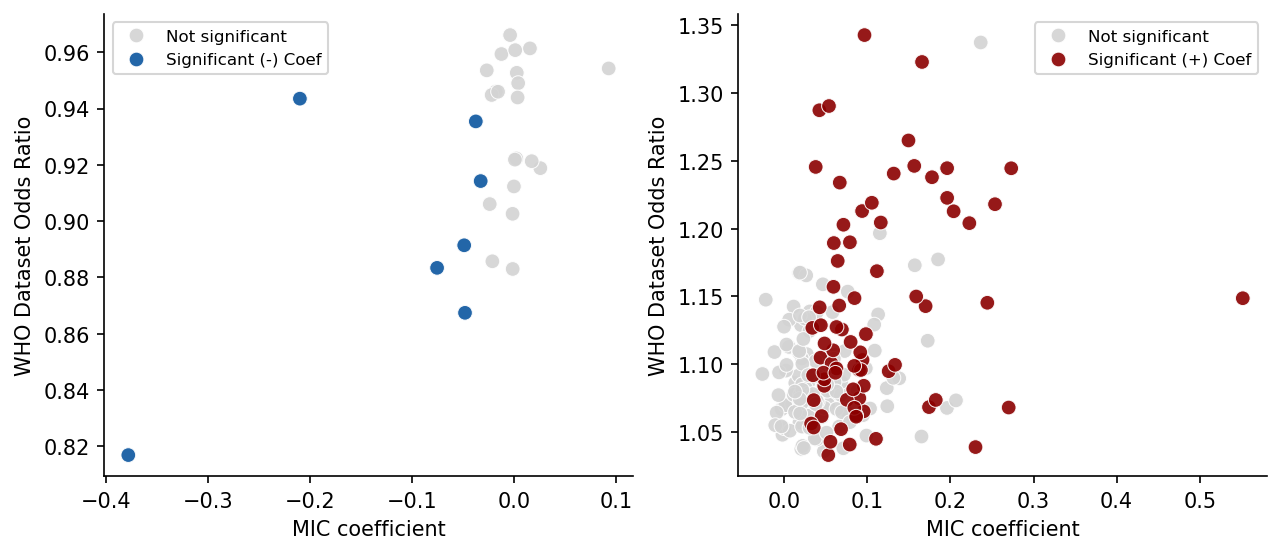

In [144]:
plot_MIC_results_with_OR(MIC_test_variants, MIC_pval_thresh, saveName="../results/Figures/WHO_MIC_volcano_plots.svg")

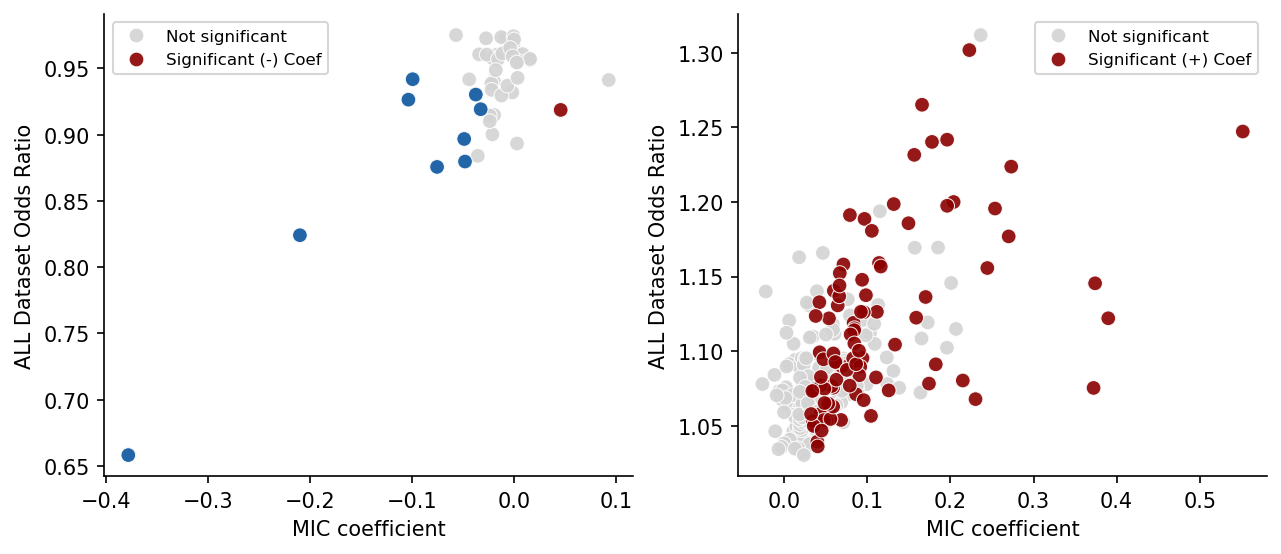

In [145]:
plot_MIC_results_with_OR(MIC_test_variants, MIC_pval_thresh, pheno_group='ALL', saveName="../results/Figures/ALL_MIC_volcano_plots.svg")

In [152]:
# MIC says positive, WHO says negative
MIC_test_variants.query("MIC_coef > 0 & MIC_BH_pval <= @MIC_pval_thresh & WHO_Odds_Ratio < 1 & WHO_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [153]:
# MIC says positive, ALL says negative. gyrA_p.Arg252Leu is significant at the FDR p-value cut-off of 0.05 for MIC coefficient, but not 0.01
# should look into the MIC values because it's not found in any MXF-R isolates, so what's happening in the MIC model
MIC_test_variants.query("MIC_coef > 0 & MIC_BH_pval <= @MIC_pval_thresh & ALL_Odds_Ratio < 1 & ALL_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset
233,Moxifloxacin,gyrA_p.Arg252Leu,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance,0.045869,0.044057,0.918637,0.0,Uncertain,Not assoc w R


In [154]:
# MIC says negative, WHO says positive
MIC_test_variants.query("MIC_coef < 0 & MIC_BH_pval <= @MIC_pval_thresh & WHO_Odds_Ratio > 1 & WHO_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [155]:
# MIC says negative, ALL says positive
MIC_test_variants.query("MIC_coef < 0 & MIC_BH_pval <= @MIC_pval_thresh & ALL_Odds_Ratio > 1 & ALL_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [21]:
who_variants.query("variant=='gyrA_p.Arg252Leu' & drug=='Moxifloxacin'")[['ALL_Present_SOLO_R', 'ALL_Present_SOLO_S', 'WHO_Present_SOLO_R', 'WHO_Present_SOLO_S', 'INITIAL CONFIDENCE GRADING', 'FINAL CONFIDENCE GRADING', 'Additional grading criteria applied']]

,ALL_Present_SOLO_R,ALL_Present_SOLO_S,WHO_Present_SOLO_R,WHO_Present_SOLO_S,INITIAL CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,Additional grading criteria applied
16111,0.0,69.0,0.0,24.0,3) Uncertain significance,3) Uncertain significance,NaN


In [156]:
MIC_results.query("mutation=='gyrA_p.Arg252Leu'")

,Drug,mutation,MIC_coef,MIC_BH_pval
7486,Levofloxacin,gyrA_p.Arg252Leu,0.023745,0.442361
8599,Moxifloxacin,gyrA_p.Arg252Leu,0.045869,0.044057


In [162]:
results_final.query("mutation=='gyrA_p.Arg252Leu' & Drug=='Moxifloxacin'")[['WHO_Present_S', 'WHO_Present_R', 'Initial confidence grading WHO dataset', 'ALL_Present_S', 'ALL_Present_R', 'Initial confidence grading ALL dataset']]

,WHO_Present_S,WHO_Present_R,Initial confidence grading WHO dataset,ALL_Present_S,ALL_Present_R,Initial confidence grading ALL dataset
16909,26.0,0.0,Uncertain,73.0,2.0,Not assoc w R


In [185]:
df_genos = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency'])

df_genos['mutation'] = df_genos['resolved_symbol'] + '_' + df_genos['variant_category']

del df_genos['resolved_symbol']
del df_genos['variant_category']

In [186]:
mutation = 'gyrA_p.Arg252Leu'

samples_with_variant = df_genos.query("mutation==@mutation & variant_allele_frequency > 0.75").sample_id.unique()
len(samples_with_variant)

75

In [187]:
df_geno_annotated = df_genos.query("variant_allele_frequency > 0.75").merge(results_final.query("Drug=='Moxifloxacin'")[['mutation', 'SOLO FINAL CONFIDENCE GRADING']], on='mutation', how='inner')

samples_with_Group12_variants = df_geno_annotated.loc[df_geno_annotated['SOLO FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sample_id.values

len(samples_with_Group12_variants)

4834

In [211]:
lineages.query("Sample_ID in @samples_with_variant").Lineage.value_counts()

Lineage
3    75
Name: count, dtype: int64

In [189]:
df_genos.query("sample_id in @samples_with_variant & variant_allele_frequency > 0.75")[['mutation']].value_counts()

mutation        
gyrA_p.Arg252Leu    75
gyrA_p.Glu21Gln     75
gyrA_p.Gly668Asp    75
gyrA_p.Ser95Thr     74
gyrA_p.Ala90Val      2
gyrA_p.Asp94Tyr      2
gyrA_c.2115C>T       1
gyrA_p.Asp94Ala      1
gyrB_p.Lys404Arg     1
Name: count, dtype: int64

In [208]:
search_variants = df_genos.query("sample_id in @samples_with_variant & variant_allele_frequency > 0.75").mutation.unique()
len(search_variants)

9

In [200]:
pd.DataFrame(df_genos.query("sample_id in @samples_with_variant & variant_allele_frequency > 0.75").mutation.value_counts()).reset_index().merge(results_final.query("Drug=='Moxifloxacin'")[['mutation', 'SOLO INITIAL CONFIDENCE GRADING', 'REGRESSION FINAL CONFIDENCE GRADING']])

,mutation,count,SOLO INITIAL CONFIDENCE GRADING,REGRESSION FINAL CONFIDENCE GRADING
0,gyrA_p.Gly668Asp,75,5) Not assoc w R,3) Uncertain significance
1,gyrA_p.Glu21Gln,75,5) Not assoc w R,4) Not assoc w R - Interim
2,gyrA_p.Arg252Leu,75,3) Uncertain significance,4) Not assoc w R - Interim
3,gyrA_p.Ser95Thr,74,5) Not assoc w R,5) Not assoc w R
4,gyrA_p.Asp94Tyr,2,1) Assoc w R,1) Assoc w R
5,gyrA_p.Ala90Val,2,1) Assoc w R,1) Assoc w R
6,gyrB_p.Lys404Arg,1,3) Uncertain significance,3) Uncertain significance
7,gyrA_c.2115C>T,1,3) Uncertain significance,3) Uncertain significance
8,gyrA_p.Asp94Ala,1,1) Assoc w R,1) Assoc w R


In [206]:
who_variants.query("drug=='Moxifloxacin' & variant in ['gyrA_p.Asp94Ala', 'gyrA_p.Asp94Tyr', 'gyrA_p.Ala90Val']")[['mutation', 'Comment']]

,mutation,Comment
16105,p.Ala90Val,"Low-level resistance (multiple, genetically li..."
16200,p.Asp94Ala,"Low-level resistance (multiple, genetically li..."
16205,p.Asp94Tyr,High-level resistance


In [196]:
results_final.query("Drug=='Moxifloxacin' & mutation in @search_variants")[['mutation', 'REGRESSION FINAL CONFIDENCE GRADING']]

,mutation,REGRESSION FINAL CONFIDENCE GRADING
15699,gyrA_p.Ala90Val,1) Assoc w R
15701,gyrA_p.Asp94Ala,1) Assoc w R
15702,gyrA_p.Asp94Tyr,1) Assoc w R
15704,gyrA_p.Gly668Asp,3) Uncertain significance
15852,gyrB_p.Lys404Arg,3) Uncertain significance
15993,gyrA_c.2115C>T,3) Uncertain significance
16905,gyrA_p.Glu21Gln,4) Not assoc w R - Interim
16909,gyrA_p.Arg252Leu,4) Not assoc w R - Interim
16914,gyrA_p.Ser95Thr,5) Not assoc w R


In [191]:
df_MIC = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Moxifloxacin/phenos_mic.csv")

df_MIC_norm, most_common_medium = normalize_MICs_return_dataframe('Moxifloxacin', df_MIC, cc_df, keep_single_medium=False)
df_MIC_norm['variant'] = df_MIC_norm['sample_id'].isin(samples_with_variant).astype(int)

df_MIC_norm_lineages = df_MIC_norm.merge(lineages, left_on='sample_id', right_on='Sample_ID')
df_MIC_norm_lineages['L3'] = (df_MIC_norm_lineages['Lineage'] == '3').astype(int)

# variable for whether an isolate is L3 and has the variant. 0 = neither, 1 = 1, and 2 = both
df_MIC_norm_lineages.loc[(df_MIC_norm_lineages['L3']==1) & (df_MIC_norm_lineages['variant']==0), 'L3_variant'] = 'L3'
df_MIC_norm_lineages.loc[(df_MIC_norm_lineages['L3']==0) & (df_MIC_norm_lineages['variant']==1), 'L3_variant'] = 'variant'
df_MIC_norm_lineages.loc[(df_MIC_norm_lineages['L3']==0) & (df_MIC_norm_lineages['variant']==0), 'L3_variant'] = 'Neither'
df_MIC_norm_lineages.loc[(df_MIC_norm_lineages['L3']==1) & (df_MIC_norm_lineages['variant']==1), 'L3_variant'] = 'L3 + variant'

# annotated Group 1-2 resistance variants
df_MIC_norm_lineages['Group_1_2_variant'] = df_MIC_norm_lineages['sample_id'].isin(samples_with_Group12_variants).astype(int)

df_MIC_norm_lineages_no_R_variants = df_MIC_norm_lineages.query("Group_1_2_variant==0")

model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl"))

    Dropped 97/12740 isolates in ['Frozen Broth Microdilution Plate (PMID31969421)', 'REMA', 'M24 BMD', '7H9'] without critical concentrations


In [192]:
# gyrA_p.Arg252Leu co-occurs with R-associated variants in 4 isolates. 2 of them are susceptible though....
df_MIC_norm_lineages.query("Group_1_2_variant==1 & variant==1")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC,...,Sample_ID,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,Lineage,L3,L3_variant,Group_1_2_variant
156,373192,UKMYC5,1.00,2.00,(,],1.500,1.0,UKMYC5,1.500,...,373192,3,3.1.1,"east_african_indian,ghana,mungi",NaN,NaN,3,1,L3 + variant,1
975,28150,UKMYC5,0.00,0.06,(,],0.030,1.0,UKMYC5,0.030,...,28150,3,3.1.1,"east_african_indian,ghana,mungi",NaN,NaN,3,1,L3 + variant,1
6143,28131,UKMYC5,1.00,2.00,(,],1.500,1.0,UKMYC5,1.500,...,28131,3,3.1.1,"east_african_indian,ghana,mungi",NaN,NaN,3,1,L3 + variant,1
8328,27178,UKMYC5,0.25,0.50,(,],0.375,1.0,UKMYC5,0.375,...,27178,3,3.1.1,"east_african_indian,mungi",NaN,NaN,3,1,L3 + variant,1


In [234]:
model_matrix.loc[[373192, 28150, 28131, 27178], ['gyrA_p.Asp94Tyr', 'gyrA_p.Ala90Val', mutation]]

mutation,gyrA_p.Asp94Tyr,gyrA_p.Ala90Val,gyrA_p.Arg252Leu
sample_id,,,
373192,1.0,0.0,1.0
28150,0.0,1.0,1.0
28131,1.0,0.0,1.0
27178,0.0,1.0,1.0


In [219]:
df_genos.query("sample_id==373192 & variant_allele_frequency > 0.75")

,sample_id,variant_allele_frequency,mutation
36286754,373192,0.97,gyrA_p.Asp94Tyr
37898617,373192,0.97,gyrA_p.Gly668Asp
38915909,373192,1.00,gyrA_p.Glu21Gln
59932241,373192,0.99,gyrA_p.Ser95Thr
63919465,373192,0.97,gyrA_p.Arg252Leu


In [221]:
df_genos.query("sample_id==28131 & variant_allele_frequency > 0.75")

,sample_id,variant_allele_frequency,mutation
36253434,28131,0.99,gyrA_p.Asp94Tyr
37878339,28131,1.00,gyrA_p.Gly668Asp
38888011,28131,1.00,gyrA_p.Glu21Gln
59937797,28131,0.98,gyrA_p.Ser95Thr
63940849,28131,1.00,gyrA_p.Arg252Leu


In [218]:
who_variants.query("drug=='Moxifloxacin' & variant=='gyrA_p.Ala90Val'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
16105,Moxifloxacin,gyrA,p.Ala90Val,gyrA_p.Ala90Val,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,946.0,536.0,...,NaN,1) Assoc w R,"Low-level resistance (multiple, genetically li...",No change,NaN,NaN,yes,NaN,F,1


In [223]:
who_variants.query("drug=='Moxifloxacin' & variant=='gyrA_p.Asp94Tyr'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
16205,Moxifloxacin,gyrA,p.Asp94Tyr,gyrA_p.Asp94Tyr,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,188.0,154.0,...,NaN,1) Assoc w R,High-level resistance,No change,NaN,NaN,yes,NaN,G,1


In [227]:
who_variants.query("drug=='Moxifloxacin' & variant=='gyrA_p.Arg252Leu'")[['WHO_Present_SOLO_S', 'WHO_Present_SOLO_R', 'ALL_Present_SOLO_S', 'ALL_Present_SOLO_R', 'Comment', 'CHANGES vs ver1']]

,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R,Comment,CHANGES vs ver1
16111,24.0,0.0,69.0,0.0,NaN,No change


In [228]:
who_variants.query("drug=='Moxifloxacin' & variant=='gyrA_p.Arg252Leu'")[['WHO_Present_S', 'WHO_Present_R', 'ALL_Present_S', 'ALL_Present_R', 'Comment', 'CHANGES vs ver1']]

,WHO_Present_S,WHO_Present_R,ALL_Present_S,ALL_Present_R,Comment,CHANGES vs ver1
16111,26.0,0.0,73.0,2.0,NaN,No change


In [186]:
# all samples with the variant are L3. So it's an L3 marker, but not all L3 isolates have it
df_MIC_norm_lineages.L3_variant.value_counts(dropna=False)

L3_variant
Neither         11626
L3                977
L3 + variant       40
Name: count, dtype: int64

In [188]:
df_MIC_norm_lineages['Group_1_2_variant'].value_counts(dropna=False)

Group_1_2_variant
0    10470
1     2173
Name: count, dtype: int64

In [123]:
df_MIC_norm_lineages.query("variant==1")['Freschi2020'].value_counts()

Freschi2020
3.1.1    40
Name: count, dtype: int64

In [35]:
# all variants that co-occur with gyrA_p.Arg252Leu are found in the MIC model matrix except a synonymous variant, which is graded Group 3 by regression
set(search_variants) - set(model_matrix.columns)

{'gyrA_c.2115C>T'}

In [41]:
cc_df.query("Drug=='Moxifloxacin' & Medium.str.contains('UKMYC')")

,Medium,Value,Drug
12,UKMYC5,1.0,Moxifloxacin
13,UKMYC6,1.0,Moxifloxacin


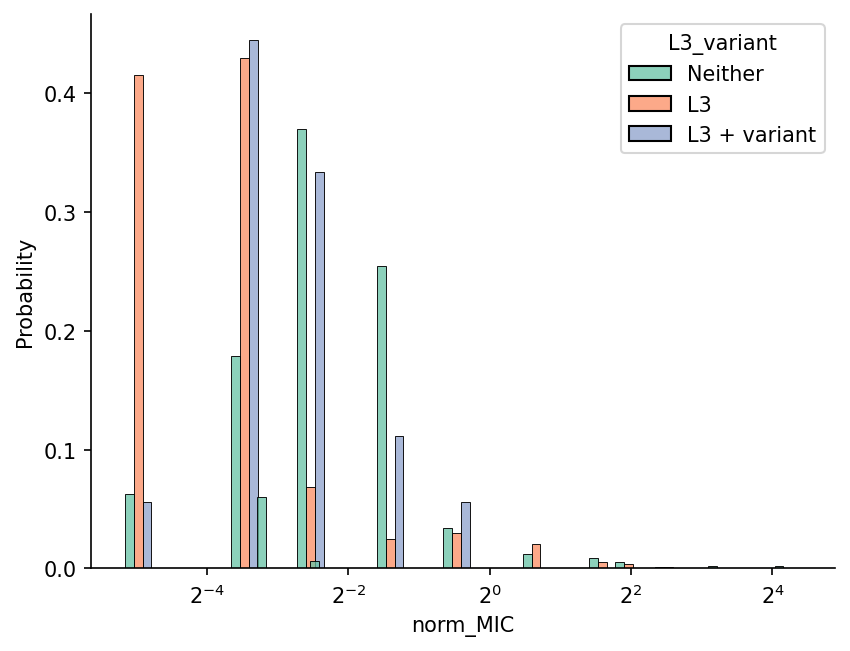

In [260]:
sns.histplot(data=df_MIC_norm_lineages_no_R_variants,
             x='norm_MIC',
             hue='L3_variant',
             log_scale=2,
             palette='Set2',
             common_norm=False,
             multiple='dodge',
             stat='probability',
             shrink=2
            )

sns.despine()
plt.show()

In [248]:
df_MIC_norm_lineages_no_R_variants.groupby("L3_variant")['norm_MIC'].mean()

L3_variant
L3              0.165402
L3 + variant    0.186667
Neither         0.360249
Name: norm_MIC, dtype: float64

In [249]:
df_MIC_norm_lineages_no_R_variants.groupby("L3_variant")['norm_MIC'].median()

L3_variant
L3              0.0900
L3 + variant    0.1375
Neither         0.1850
Name: norm_MIC, dtype: float64

In [250]:
# sns.histplot(data=df_MIC_norm_lineages_no_R_variants,
#              x='norm_MIC',
#              hue='L3',
#              log_scale=2,
#              palette='Set2',
#              common_norm=False,
#              multiple='dodge',
#              stat='probability',
#              shrink=2
#             )

# sns.despine()
# plt.show()

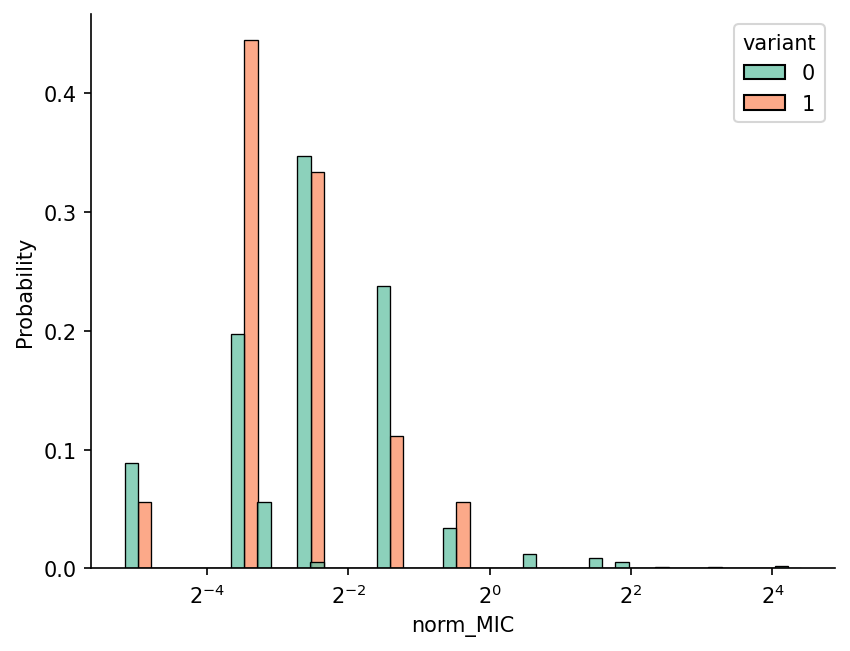

In [238]:
sns.histplot(data=df_MIC_norm_lineages_no_R_variants,
             x='norm_MIC',
             hue='variant',
             log_scale=2,
             palette='Set2',
             common_norm=False,
             multiple='dodge',
             stat='probability',
             shrink=2
            )

sns.despine()
plt.show()

In [236]:
len(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3 + variant'")), len(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3'"))

(36, 772)

In [204]:
# MIC median is higher for L3 + variant than L3
st.mannwhitneyu(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3 + variant'")['norm_MIC'],
                df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3'")['norm_MIC'],
                alternative='greater'
               )

MannwhitneyuResult(statistic=20602.0, pvalue=5.921345597540233e-08)

In [255]:
# MIC median is higher for L3 + variant than L3
st.ttest_ind(np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3 + variant'")['norm_MIC']),
                np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='L3'")['norm_MIC']),
                alternative='greater',
            equal_var=False
               )

TtestResult(statistic=5.312051827284072, pvalue=1.9949524286243956e-06, df=41.39568350346555)

In [205]:
# MIC median is lower for L3 than non L3, regardless of variant presence or absence
st.mannwhitneyu(df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['L3', 'L3 + variant']")['norm_MIC'],
                df_MIC_norm_lineages_no_R_variants.query("L3_variant=='Neither'")['norm_MIC'],
                alternative='less'
               )

MannwhitneyuResult(statistic=1552479.0, pvalue=7.930895783217265e-191)

In [257]:
# MIC median is lower for L3 than non L3, regardless of variant presence or absence
st.ttest_ind(np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['L3', 'L3 + variant']")['norm_MIC']),
                np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant=='Neither'")['norm_MIC']),
                alternative='less',
            equal_var=False
               )

TtestResult(statistic=-26.54160211382893, pvalue=6.328928925911023e-116, df=917.1162076086615)

In [237]:
# MIC median is lower for isolates with variant than without it
st.mannwhitneyu(df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['L3 + variant']")['norm_MIC'],
                df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['Neither', 'L3']")['norm_MIC'],
                alternative='less'
               )

MannwhitneyuResult(statistic=150765.0, pvalue=0.01721035858858804)

In [258]:
# MIC median is lower for isolates with variant than without it
st.ttest_ind(np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['L3 + variant']")['norm_MIC']),
                np.log2(df_MIC_norm_lineages_no_R_variants.query("L3_variant in ['Neither', 'L3']")['norm_MIC']),
                alternative='less',
            equal_var=False
               )

TtestResult(statistic=-2.0219249383465896, pvalue=0.025396591184099888, df=35.39791181533758)

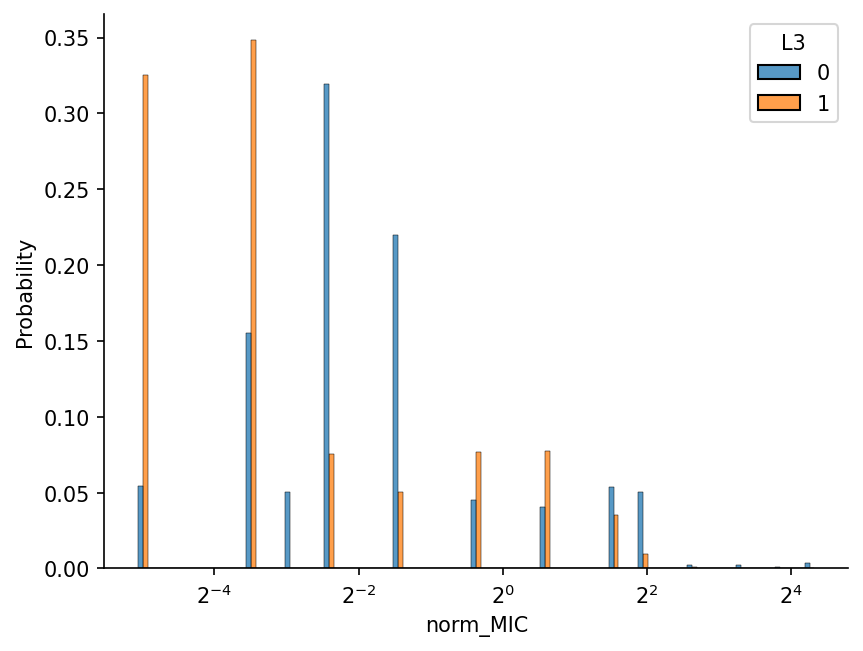

In [80]:
sns.histplot(data=df_MIC_norm_lineages,
             x='norm_MIC',
             hue='L3',
             log_scale=2,
             common_norm=False,
             multiple='dodge',
             stat='probability'
            )

sns.despine()
plt.show()

# Lineage Distributions for Group 3 Mutations by SOLO + GR that are Graded R-assoc by Regression

In [11]:
regression_upgrades = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')]
print(f"{len(regression_upgrades)} variants across {regression_upgrades.Drug.nunique()} drugs are graded Groups 1-2 by regression and Group 3 by SOLO + GR")

lineages_isolates_with_new_muts = pd.read_csv("../lineages/isolates_with_new_muts.csv")

# assert len(set(regression_upgrades.mutation).symmetric_difference(lineages_isolates_with_new_muts.mutation)) == 0
assert len(set(regression_upgrades.mutation) - set(lineages_isolates_with_new_muts.mutation)) == 0

# combine with gradings
lineages_isolates_with_new_muts = lineages_isolates_with_new_muts.merge(regression_upgrades[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING']].rename(columns={'REGRESSION FINAL CONFIDENCE GRADING': 'confidence'}), on=['Drug', 'mutation'])

220 variants across 12 drugs are graded Groups 1-2 by regression and Group 3 by SOLO + GR


In [12]:
results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['REGRESSION GRADING + LOF UPGRADE'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(36, 66)

In [14]:
def get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=True, lineage_col='Coll2014'):

    single_drug_df = lineages_isolates_with_new_muts.query("Drug==@drug")
    
    # group lineage counts by both mutation and phenotype
    if resistant:
        single_drug_df = pd.DataFrame(single_drug_df.query("confidence.str.contains('Assoc w R')").groupby(['mutation', 'phenotype'])[lineage_col].value_counts()).reset_index()
    else:
        single_drug_df = pd.DataFrame(single_drug_df.query("confidence.str.contains('Not assoc w R')").groupby(['mutation', 'phenotype'])[lineage_col].value_counts()).reset_index()

    # remove multi-lineage instances
    single_drug_df = single_drug_df.query(f"~{lineage_col}.str.contains(',')")

    # create additional rows for (mutation, phenotype) combinations that are not present. i.e. if all L2.1.1 isolates are RIF-R, create a row of 0 for L2.2.1 + RIF-S
    for lineage in single_drug_df[lineage_col].unique():
    
        for mutation in single_drug_df.mutation.unique():
    
            for phenotype in [0, 1]:
                
                if len(single_drug_df.query(f"mutation==@mutation & {lineage_col}==@lineage & phenotype==@phenotype")) == 0:
                    
                    single_drug_df = pd.concat([single_drug_df, pd.DataFrame({'mutation': mutation,
                                                                                            'phenotype': phenotype,
                                                                                            lineage_col: lineage,
                                                                                            'count': 0
                                                                                           }, index=[0])]).reset_index(drop=True)
    
    # check that the dataframe is exhaustive of all the groups now
    assert len(single_drug_df) == single_drug_df.mutation.nunique() * single_drug_df.phenotype.nunique() * single_drug_df[lineage_col].nunique()
    
    # sort for plotting
    return single_drug_df.sort_values(['mutation', lineage_col, 'phenotype'])

In [15]:
def plot_heatmap_new_mutations(drug, resistant=True, lineage_col='Coll2014', saveName=None):

    single_drug_df = get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=resistant, lineage_col=lineage_col)

    # for readability, plot only the 10 most common mutations
    # for INH, exclude ahpC promoter mutations as they are already known to be relevant for resistance
    plot_mutations = pd.DataFrame(single_drug_df.groupby('mutation')['count'].sum()).query("~mutation.str.startswith('ahpC_c.')").sort_values('count', ascending=False).index.values[:10]

    matrix = single_drug_df.query("mutation in @plot_mutations").pivot(index=lineage_col, columns=['mutation', 'phenotype'], values='count')

    # use 1 inch per subplot
    color_maps = ['Blues', 'Reds']

    # don't share axes because need to set the axis ticks and labels only for certain subplot but not all
    fig, axs = plt.subplots(1, matrix.shape[1], figsize=(matrix.shape[1]*0.7, matrix.shape[0]*0.25), sharex=False, sharey=False)

    # normalize the color by the total number of isolates in the entire heatmap
    # vmax = matrix.values.max()
    # max_R = matrix.loc[:, matrix.columns.get_level_values(1) == 1].values.max()
    # max_S = matrix.loc[:, matrix.columns.get_level_values(1) == 0].values.max()
    
    mutations_lst = matrix.columns.get_level_values(0)
    
    for col_idx, ax in enumerate(axs):
    
        vals_to_plot = matrix.loc[:, matrix.columns[col_idx]].values

        # # odd numbered plots are resistant, even is susceptible
        # if col_idx % 2 == 0:
        #     vmax = max_S
        # else:
        #     vmax = max_R

        # normalize the color by the total number of isolates for a given mutation
        # get the first value in the column names (mutation, phenotype)
        vmax = matrix.loc[:, matrix.columns.get_level_values(0) == matrix.columns[col_idx][0]].values.max()
        
        sns.heatmap(vals_to_plot.reshape(-1, 1), 
                    ax=ax, 
                    annot=True,
                    fmt='d',
                    vmin=0,
                    vmax=vmax,
                    annot_kws={'fontsize': 7},
                    linewidth=0.25, 
                    linecolor='black',
                    cmap=color_maps[col_idx % len(color_maps)], 
                    cbar=False
                   )
    
        # remove horizontal space between columns (mutations)
        plt.subplots_adjust(wspace=0)
    
        if col_idx != 0:
            # turn off y axes for all except the first plot
            ax.get_yaxis().set_visible(False)
        else:
            ax.set_yticklabels(labels=matrix.index.values, fontsize=7, rotation=0)

        # label every other plot so that each mutation name is only listed once
        if col_idx % 2 == 0:
            ax.set_xticks([1])
            ax.set_xticklabels(labels=[mutations_lst[col_idx]], fontsize=7)
        else:
            ax.set_xticks([])

    # plt.title(f"Lineage and Phenotypic Breakdown of New Mutations for {drug}")
    sns.despine(top=False, right=False, left=False, bottom=False)

    if saveName is not None:
        plt.savefig(saveName, format='svg', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [16]:
plot_heatmap_new_mutations('Rifampicin', resistant=True, saveName='../results/Figures/S6_RIF.svg')

In [17]:
plot_heatmap_new_mutations('Isoniazid', resistant=True, saveName='../results/Figures/S6_INH.svg')

In [18]:
plot_heatmap_new_mutations('Moxifloxacin', resistant=True, saveName='../results/Figures/S6_MXF.svg')

In [19]:
plot_heatmap_new_mutations('Levofloxacin', resistant=True, saveName='../results/Figures/S6_LFX.svg')

In [20]:
plot_heatmap_new_mutations('Ethambutol', resistant=True, saveName='../results/Figures/S6_EMB.svg')

In [21]:
plot_heatmap_new_mutations('Ethionamide', resistant=True, saveName='../results/Figures/S6_ETO.svg')

In [22]:
plot_heatmap_new_mutations('Pyrazinamide', resistant=True, saveName='../results/Figures/S6_PZA.svg')

In [23]:
plot_heatmap_new_mutations('Streptomycin', resistant=True, saveName='../results/Figures/S6_STM.svg')

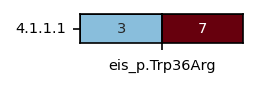

In [28]:
plot_heatmap_new_mutations('Amikacin', resistant=True)

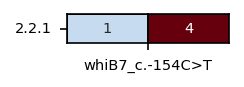

In [29]:
plot_heatmap_new_mutations('Kanamycin', resistant=True)

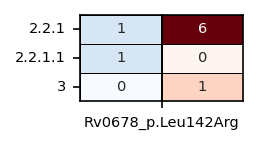

In [30]:
plot_heatmap_new_mutations('Bedaquiline', resistant=True)

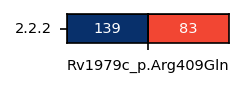

In [31]:
plot_heatmap_new_mutations('Clofazimine', resistant=True)

In [34]:
# nothing for these
# plot_heatmap_new_mutations('Capreomycin', resistant=True)
# plot_heatmap_new_mutations('Delamanid', resistant=True)

In [52]:
lineage_new_muts_supplement_df = []
resistant = True
lineage_col = 'Coll2014'

for drug in regression_upgrades.Drug.unique():

    single_drug_df = get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=resistant, lineage_col=lineage_col)
    single_drug_df['Drug'] = drug
    lineage_new_muts_supplement_df.append(single_drug_df)

lineage_new_muts_supplement_df = pd.concat(lineage_new_muts_supplement_df)
lineage_new_muts_supplement_df = lineage_new_muts_supplement_df.query("count > 0")
lineage_new_muts_supplement_df['Lineage'] = lineage_new_muts_supplement_df['Coll2014'].str[0]

# # bovis, canettii, etc.
lineage_new_muts_supplement_df.loc[lineage_new_muts_supplement_df['Lineage'].str.isalpha(), 'Lineage'] = lineage_new_muts_supplement_df.loc[lineage_new_muts_supplement_df['Lineage'].str.isalpha()]['Coll2014']
lineage_new_muts_supplement_df[['Drug', 'mutation', 'phenotype', 'Coll2014', 'Lineage', 'count']].to_csv("../tables/lineage_dist_regression_upgrades.csv", index=False)

In [53]:
lineage_new_muts_supplement_df = pd.read_csv("../tables/lineage_dist_regression_upgrades.csv")
np.sort(lineage_new_muts_supplement_df.Lineage.unique())

array(['1', '2', '3', '4', '5', 'BOV_AFRI'], dtype=object)

In [57]:
lineage_new_muts_supplement_df[['Drug', 'mutation']].drop_duplicates().shape

(220, 2)

# Summary Information on the Lineage Distributions for the Regression Upgrades

In [58]:
lineage_col = 'Lineage'

df_new_lineage_summary = pd.DataFrame(lineage_new_muts_supplement_df.groupby(['Drug', 'mutation'])[lineage_col].nunique()).reset_index()
len(df_new_lineage_summary)

220

In [59]:
len(df_new_lineage_summary.query(f"{lineage_col} == 1")), len(df_new_lineage_summary.query(f"{lineage_col} > 1"))

(42, 178)

In [62]:
# prop of variants present in more than one primary lineage
177/221, 178/220

(0.8009049773755657, 0.8090909090909091)

In [63]:
lineage_restricted_variants = df_new_lineage_summary.query(f"{lineage_col}==1")[['Drug', 'mutation']]

In [64]:
lineage_restricted_variants_counts = pd.DataFrame(lineage_new_muts_supplement_df.merge(lineage_restricted_variants, on=['Drug', 'mutation']).groupby(['Drug', 'mutation'])['count'].sum()).reset_index()

lineage_restricted_variants_counts[['Drug', 'mutation']].drop_duplicates().shape

(42, 2)

In [65]:
lineage_new_muts_supplement_df.query("mutation=='eis_p.Trp36Arg'")

,Drug,mutation,phenotype,Coll2014,Lineage,count
0,Amikacin,eis_p.Trp36Arg,0,4.1.1.1,4,3
1,Amikacin,eis_p.Trp36Arg,1,4.1.1.1,4,7


In [66]:
lineage_restricted_variants_counts.query("count < 10")[['Drug', 'mutation']].drop_duplicates().shape, lineage_restricted_variants_counts.query("count >= 10")[['Drug', 'mutation']].drop_duplicates().shape

((17, 2), (25, 2))

In [69]:
pd.DataFrame(lineage_new_muts_supplement_df.merge(lineage_restricted_variants, on=['Drug', 'mutation']).groupby(['Drug', 'mutation'])['Coll2014'].unique()).reset_index()

,Drug,mutation,Coll2014
0,Amikacin,eis_p.Trp36Arg,[4.1.1.1]
1,Clofazimine,Rv1979c_p.Arg409Gln,[2.2.2]
2,Ethambutol,embA_p.Thr608Asn,[4.6.1.2]
3,Ethambutol,embB_p.Asn296His,[2.2.1]
4,Ethambutol,embB_p.Val456Ala,[2.2.1.1]
5,Ethambutol,embC_c.-10A>C,[4.1.2.1]
6,Ethambutol,embC_c.-531C>T,[2.2.1]
7,Ethambutol,embC_c.-632G>A,[2.2.1]
8,Ethambutol,ubiA_p.Leu31Pro,"[4.1.2.1, 4.2.1, 4.3.3, 4.3.4.1, 4.5, 4.7, 4.8]"
9,Ethionamide,ethA_p.Ala222_Ile338del,[4.1.2.1]


# S-Associated Variants: only describe those with MIC evidence also in the paper

In [174]:
S_assoc_variants = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc')) & (results_final['Initial confidence grading WHO dataset'] != 'Neutral')& (results_final['Initial confidence grading ALL dataset'] != 'Neutral')].reset_index(drop=True)

S_assoc_variants = S_assoc_variants.merge(MIC_results, on=['Drug', 'mutation'], how='left')

S_assoc_variants = S_assoc_variants.merge(who_variants[['drug', 'variant', 'WHO_Present_SOLO_S', 'WHO_Present_SOLO_R', 'ALL_Present_SOLO_S', 'ALL_Present_SOLO_R']].rename(columns={'drug': 'Drug', 'variant': 'mutation'}), on=['Drug', 'mutation'], how='left')

print(len(S_assoc_variants), S_assoc_variants.Drug.nunique())

132 13


In [175]:
S_assoc_variants.query("ALL_Present_SOLO_S > ALL_Present_SOLO_R | (MIC_coef < 0 & MIC_BH_pval <= 0.05)").shape

(91, 72)

In [176]:
S_assoc_variants.query("ALL_Present_SOLO_S > ALL_Present_SOLO_R & (MIC_coef < 0 & MIC_BH_pval <= 0.05)")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R
8,Bedaquiline,mmpL5,mmpL5_LoF,LoF,0.805117,0.014,0.040676,0.982,1.0,1.183522e-02,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.323631,0.000000,2.0,0.0,209.0,0.0
15,Clofazimine,Rv1979c,Rv1979c_c.-50A>C,upstream_gene_variant,0.929599,0.036,0.202378,0.882,1.0,1.503049e-01,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.064340,0.000000,3.0,0.0,52.0,0.0
29,Ethambutol,embC,embC_c.-900C>T,upstream_gene_variant,0.921245,0.025,0.226586,0.944,1.0,3.314202e-01,...,5) Not assoc w R,5) Not assoc w R,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.242851,0.000000,594.0,7.0,885.0,12.0
66,Kanamycin,whiB7,whiB7_c.-100T>C,upstream_gene_variant,0.917472,0.008,0.046596,0.987,1.0,3.229649e-01,...,5) Not assoc w R,5) Not assoc w R,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.054090,0.024316,72.0,0.0,227.0,2.0
68,Kanamycin,eis,eis_LoF,LoF,1.050366,0.030,0.164211,0.908,1.0,1.000000e+00,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.108152,0.000000,40.0,5.0,158.0,5.0
82,Levofloxacin,gyrA,gyrA_p.Ser95Thr,missense_variant,0.611583,0.000,0.000000,1.000,1.0,1.435003e-17,...,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,-0.383087,0.000000,18.0,0.0,22.0,1.0
86,Moxifloxacin,gyrA,gyrA_p.Ser95Thr,missense_variant,0.717544,0.000,0.000000,1.000,1.0,2.161930e-08,...,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,-0.178469,0.000000,12.0,0.0,17.0,0.0


In [177]:
S_assoc_variants[['SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].value_counts()

SOLO INITIAL CONFIDENCE GRADING  SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance        3) Uncertain significance        61
5) Not assoc w R                 5) Not assoc w R                 54
3) Uncertain significance        4) Not assoc w R - Interim       13
4) Not assoc w R - Interim       4) Not assoc w R - Interim        3
3) Uncertain significance        2) Assoc w R - Interim            1
Name: count, dtype: int64

In [182]:
len(S_assoc_variants)

132

In [178]:
S_assoc_variants.loc[S_assoc_variants['SOLO FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R
41,Ethionamide,ethA,ethA_p.Pro209fs,frameshift,0.913251,0.001,0.003481,0.999,1.0,0.182828,...,3) Uncertain significance,2) Assoc w R - Interim,4) Not assoc w R - Interim,4) Not assoc w R - Interim,NaN,NaN,26.0,0.0,26.0,0.0


In [179]:
# number with significant MIC coefficients
S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05").shape, S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05").Drug.nunique()

((15, 72), 8)

In [180]:
# good, no significant positive MIC coefficients
S_assoc_variants.query("MIC_coef > 0 & MIC_BH_pval <= 0.05")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R


In [185]:
S_assoc_variants_save = S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05")[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_Present_SOLO_S', 'ALL_Present_SOLO_R', 'MIC_coef', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].sort_values(['Drug', 'REGRESSION FINAL CONFIDENCE GRADING', 'ALL_Odds_Ratio'], ascending=[True, False, True])

print(len(S_assoc_variants_save))

S_assoc_variants_save.to_csv("../tables/S_assoc_variants.csv", index=False)

15


In [187]:
S_assoc_variants_save[['SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].value_counts()

SOLO INITIAL CONFIDENCE GRADING  SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance        3) Uncertain significance        9
5) Not assoc w R                 5) Not assoc w R                 5
3) Uncertain significance        4) Not assoc w R - Interim       1
Name: count, dtype: int64

In [191]:
S_assoc_variants_save.loc[S_assoc_variants_save['SOLO FINAL CONFIDENCE GRADING'] == '3) Uncertain significance']

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,ALL_Present_SOLO_S,ALL_Present_SOLO_R,MIC_coef,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
5,Amikacin,eis_p.His150fs,0.867707,0.000000,0.880061,0.000000,0.0,0.0,-0.047640,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance
3,Amikacin,eis_p.Met1?,0.913777,0.000000,0.919073,0.000000,0.0,0.0,-0.032858,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance
1,Amikacin,eis_c.-9T>C,0.935909,0.000000,0.930504,0.000000,0.0,0.0,-0.037033,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
8,Bedaquiline,mmpL5_LoF,0.805117,0.040676,0.888159,0.000000,209.0,0.0,-0.323631,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
7,Bedaquiline,mmpL5_p.Arg202fs,0.949988,0.079258,0.914969,0.000000,0.0,0.0,-0.217665,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
15,Clofazimine,Rv1979c_c.-50A>C,0.929599,0.202378,0.906902,0.023324,52.0,0.0,-0.064340,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
74,Kanamycin,eis_p.His150fs,0.885567,0.000000,0.875896,0.000000,0.0,0.0,-0.074057,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
71,Kanamycin,eis_p.Met1?,0.889970,0.000000,0.897791,0.000000,0.0,0.0,-0.049581,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
68,Kanamycin,eis_LoF,1.050366,0.164211,0.928993,0.000000,158.0,5.0,-0.108152,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance


# Not AwR Variants from Literature

In [105]:
# keep only tier 1 variants
NotAwR_by_literature = pd.read_excel("../data/NotAwR by literature.xlsx", sheet_name='Sheet1').merge(who_variants[['drug', 'variant']], how='inner')
NotAwR_by_literature.rename(columns={'drug': 'Drug', 'variant': 'mutation'}, inplace=True)

# merge with regressionr esults
NotAwR_by_literature = results_final.merge(NotAwR_by_literature)
NotAwR_by_literature.shape

(28, 66)

In [106]:
NotAwR_by_literature['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
3) Uncertain significance     27
4) Not assoc w R - Interim     1
Name: count, dtype: int64

In [111]:
NotAwR_by_literature.loc[NotAwR_by_literature['REGRESSION FINAL CONFIDENCE GRADING'] != '3) Uncertain significance'][['Drug', 'mutation', 'WHO_BH_pval', 'WHO_BH_neutral_pval', 'ALL_BH_pval', 'ALL_BH_neutral_pval']]

,Drug,mutation,WHO_BH_pval,WHO_BH_neutral_pval,ALL_BH_pval,ALL_BH_neutral_pval
22,Levofloxacin,gyrA_p.Arg252Leu,0.036119,1.0,0.785241,0.686341


# Neutral Example for Figure S3

In [63]:
thresh = 0.05
solo_neutral = who_variants.query("WHO_Neutral_masked==True").variant.values

results_final.query("WHO_BH_pval > @thresh & WHO_BH_neutral_pval <= @thresh & WHO_Present_SR >= 5 & mutation in @solo_neutral")[['Drug', 'mutation', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,Drug,mutation,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
2863,Clofazimine,Rv1979c_c.-129A>G,5) Not assoc w R,5) Not assoc w R
13741,Levofloxacin,gyrA_p.Gly247Ser,5) Not assoc w R,5) Not assoc w R
18812,Rifampicin,rpoB_p.Ser388Leu,5) Not assoc w R,5) Not assoc w R


In [64]:
def plot_permutation_df(permute_df, coef_df, model_analysis, variant, saveName=None):

    fig, ax = plt.subplots(figsize=(4, 3))

    y_array = np.exp(permute_df[variant])
    OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 2)

    if OR == 1:
        OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 4)
    
    sns.histplot(x=y_array,
                 ax=ax,
                )
    
    plt.axvline(x=np.exp(coef_df.query("mutation==@variant")['coef'].values[0]), color='tomato', label=f'OR = {OR}')
    plt.title(f"Permuted Model ORs for {variant}", fontsize='9')
    plt.xlabel("Odds Ratio", fontsize='9')
    plt.ylabel('', fontsize='9')

    plt.xticks(fontsize='8')
    plt.yticks(ticks=[], fontsize='8')
    plt.legend(fontsize='7')
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches='tight')

p-value: 0.016


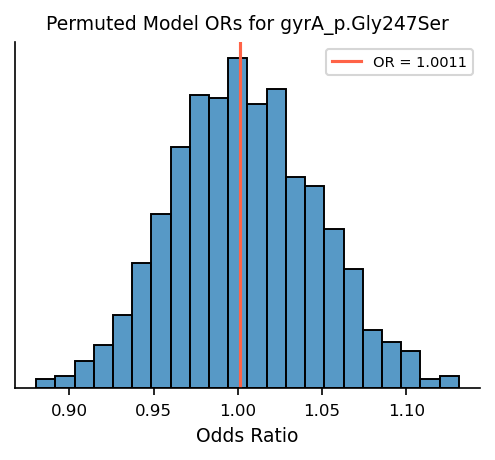

In [68]:
drug = 'Levofloxacin'
model_prefix = 'dropAF_noSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

neutral_variant = 'gyrA_p.Gly247Ser'
pval = model_analysis.query("mutation==@neutral_variant")['neutral_pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, neutral_variant, saveName='../results/Figures/neutral_permutation_example.svg')

p-value: 0.0


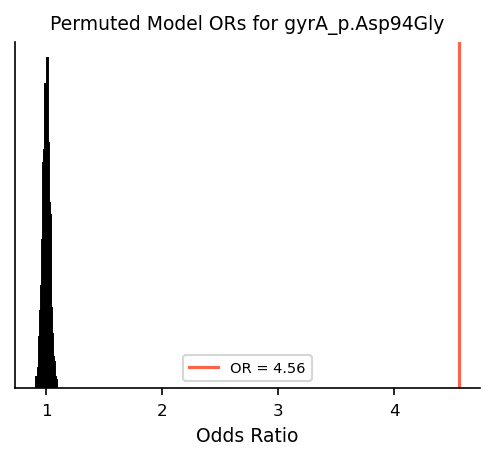

In [70]:
drug = 'Moxifloxacin'
model_prefix = 'dropAF_noSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

R_assoc_variant = 'gyrA_p.Asp94Gly'
# S_assoc_variant = 'gyrA_p.Ser95Thr'

pval = model_analysis.query("mutation==@R_assoc_variant")['pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, R_assoc_variant, saveName='../results/Figures/R_assoc_permutation_example.svg')

# pval = model_analysis.query("mutation==@S_assoc_variant")['pval'].values[0]
# print(f"p-value: {pval}")
# plot_permutation_df(permute_df, coef_df, model_analysis, S_assoc_variant)#, saveName='../supplement/Figures/S_assoc_permutation.png')

# Chi-Squared Distribution (just for illustration purposes)

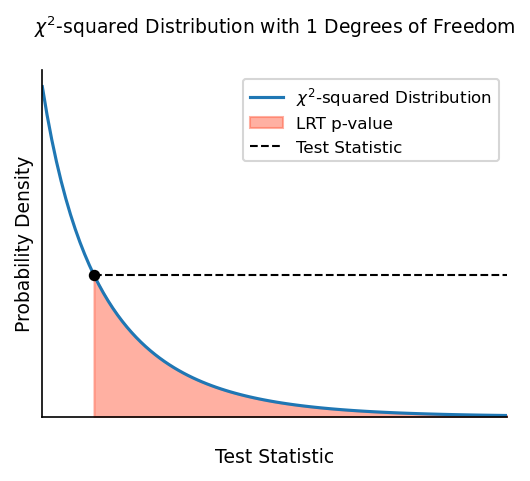

In [74]:
# Generate values for the chi-squared distribution
min_val = 1
max_val = 10
chi_stat = 2
dof = 1

fig, ax = plt.subplots(figsize=(4, 3))
x = np.linspace(min_val, max_val, 100)  # Adjust the range as needed
chi_squared_values = st.chi2.pdf(x, df=dof)

# Plot the chi-squared distribution
plt.plot(x, chi_squared_values, label=f'$\\chi^2$-squared Distribution')

# Highlight the area under the curve for the test statistic
# plt.fill_between(x, chi_squared_values, where=(x <= chi_stat), color='purple', alpha=0.5, label='LRT neutral p-value')
plt.fill_between(x, chi_squared_values, where=(x >= chi_stat), color='tomato', alpha=0.5, label='LRT p-value')
plt.hlines(y=st.chi2.pdf(chi_stat, df=dof), xmin=chi_stat, xmax=max_val, linestyle='--', linewidth=1, color='black', label='Test Statistic')
plt.scatter(x=chi_stat, y=st.chi2.pdf(chi_stat, df=dof), color='black', s=20, zorder=4)

# Add labels and legend
plt.title(f'$\\chi^2$-squared Distribution with {dof} Degrees of Freedom\n', fontsize='9')
plt.xlabel('\nTest Statistic', fontsize='9')
plt.ylabel('Probability Density', fontsize='9')
plt.legend(fontsize='8')

# Show plot
# plt.grid(True)
sns.despine()
plt.xlim(min_val, max_val)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.ylim(0, )
plt.savefig("../results/Figures/S3C_LRT.svg", format='svg', bbox_inches='tight')